In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import csv
import pandas

In [2]:
def CsvToPandas(csvfile):
    csv_data = list()
    for row in csvfile:
        if row[0].startswith('unit.'):
            csv_data.append(float(row[-2]))
    csvdata=np.array(csv_data)
    return csvdata.max()

In [3]:
def SparkLogToDataFrame(filename,path):
    import json
    import pandas
    import numpy as np

    columns=['TaskId','LaunchTime','SchedulerDelay','DeserializeTime','Runtime','ResultSerialization','FinishTime','ResultSize']

    stat_file=open(path+filename)
    stats=list();
    for line in stat_file:
        stats.append(json.loads(line))

    data=pandas.DataFrame(columns=columns,dtype=np.int64)
    data_point = np.zeros((8,1),dtype=np.int64)
    for stat in stats:
        if stat['Event'] == 'SparkListenerTaskEnd':
            data_point[0] = int(stat['Task Info']['Task ID'])
            data_point[1] = int(stat['Task Info']['Launch Time'])
            data_point[3] = int(stat['Task Metrics']['Executor Deserialize Time'])
            data_point[4] = int(stat['Task Metrics']['Executor Run Time'])
            data_point[5] = int(stat['Task Metrics']['Result Serialization Time'])
            data_point[6] = int(stat['Task Info']['Finish Time'])
            data_point[7] = int(stat['Task Metrics']['Result Size'])
            data_point[2] = data_point[6] - (data_point[1] + data_point[3] \
                                           + data_point[4] + data_point[5])
            data_case = pandas.DataFrame(data_point.reshape((1,8)),columns=columns)
            data = data.append(data_case,ignore_index=True)
            
    return data


In [14]:
def SparkSessionToDataFrame(sessionName,path,appName):
    import json
    import pandas
    import numpy as np

    columns=['TaskId','LaunchTime','SchedulerDelay','DeserializeTime','Runtime','ResultSerialization','FinishTime','ResultSize','ReadTime','Exec']
    data=pandas.DataFrame(np.zeros((1,10)),columns=columns,dtype=np.int64)
    data_point = np.zeros((10,1),dtype=np.int64)
    
    if appName != 'miss':
        appPath = path + sessionName + '/unit.000000/' + appName
        print appPath
        timings = np.load(path + sessionName + '/unit.000000/timing.npz.npy')

        stat_file=open(appPath)
        stats=list();
        for line in stat_file:
            stats.append(json.loads(line))

        for stat in stats:
            if stat['Event'] == 'SparkListenerTaskEnd':
                data_point[0] = int(stat['Task Info']['Task ID'])
                data_point[1] = int(stat['Task Info']['Launch Time'])
                data_point[3] = int(stat['Task Metrics']['Executor Deserialize Time'])
                data_point[4] = int(stat['Task Metrics']['Executor Run Time'])
                data_point[5] = int(stat['Task Metrics']['Result Serialization Time'])
                data_point[6] = int(stat['Task Info']['Finish Time'])
                data_point[7] = int(stat['Task Metrics']['Result Size'])
                data_point[2] = data_point[6] - (data_point[1] + data_point[3] \
                                           + data_point[4] + data_point[5])
                data_point[8] = timings[data_point[0],1]-timings[data_point[0],0]
                data_point[9] = timings[data_point[0],2]-timings[data_point[0],1]
                data_case = pandas.DataFrame(data_point.reshape((1,10)),columns=columns)
                data = data.append(data_case,ignore_index=True)
            
    return data

In [5]:
def SessionToPandas(path,sessionName,cores):
    
    unit_path = path+sessionName+'/'
    
    sessionDataFrame = pandas.DataFrame(columns=['Read','Exec','Write'],dtype=np.float)
    for i in range(0,cores):
        data_point = np.zeros((1,3),dtype=np.float)
        stdoutFile = open(unit_path + 'unit.%06i'%i+'/STDOUT')
        for line in stdoutFile:
            if line.startswith('Data Read:'):
                lineList=line.split()
                data_point[0,0] = np.float(lineList[2])
                data_point[0,1] = np.float(lineList[5])
            elif line.startswith('Total Time'):
                lineList = line.split()
                data_point[0,2] = np.float(lineList[6]) - data_point[0,0] - data_point[0,1]
            
        sessionDataFrame = sessionDataFrame.append(pandas.DataFrame((data_point),columns=['Read','Exec','Write']),ignore_index=True)
            
    return sessionDataFrame

# 1. Vanilla Experiments

## 1.1 Setting up everything

In [6]:
rp_haus_21_32_short_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_21_32_short_ca_1.csv',index_col=None)
rp_haus_21_32_short_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_21_32_short_ca_2.csv',index_col=None)
rp_haus_21_32_short_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_21_32_short_ca_3.csv',index_col=None)
rp_haus_36_24_short_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_36_24_short_ca_1.csv',index_col=None)
rp_haus_36_24_short_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_36_24_short_ca_2.csv',index_col=None)
rp_haus_36_24_short_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_36_24_short_ca_3.csv',index_col=None)
rp_haus_78_16_short_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_78_16_short_ca_1.csv',index_col=None)
rp_haus_78_16_short_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_78_16_short_ca_2.csv',index_col=None)
rp_haus_78_16_short_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_78_16_short_ca_3.csv',index_col=None)
rp_haus_136_12_short_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_136_12_short_ca_1.csv',index_col=None)
rp_haus_136_12_short_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_136_12_short_ca_2.csv',index_col=None)
rp_haus_136_12_short_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_136_12_short_ca_3.csv',index_col=None)
rp_haus_300_8_short_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_300_8_short_ca_1.csv',index_col=None)
rp_haus_300_8_short_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_300_8_short_ca_2.csv',index_col=None)
rp_haus_300_8_short_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_300_8_short_ca_3.csv',index_col=None)
rp_haus_528_6_short_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_528_6_short_ca_1.csv',index_col=None)
rp_haus_528_6_short_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_528_6_short_ca_2.csv',index_col=None)
rp_haus_528_6_short_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_528_6_short_ca_3.csv',index_col=None)

rp_haus_21_32_med_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_21_32_med_ca_1.csv',index_col=None)
rp_haus_21_32_med_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_21_32_med_ca_2.csv',index_col=None)
rp_haus_21_32_med_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_21_32_med_ca_3.csv',index_col=None)
rp_haus_36_24_med_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_36_24_med_ca_1.csv',index_col=None)
rp_haus_36_24_med_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_36_24_med_ca_2.csv',index_col=None)
rp_haus_36_24_med_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_36_24_med_ca_3.csv',index_col=None)
rp_haus_78_16_med_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_78_16_med_ca_1.csv',index_col=None)
rp_haus_78_16_med_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_78_16_med_ca_2.csv',index_col=None)
rp_haus_78_16_med_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_78_16_med_ca_3.csv',index_col=None)
rp_haus_136_12_med_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_136_12_med_ca_1.csv',index_col=None)
rp_haus_136_12_med_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_136_12_med_ca_2.csv',index_col=None)
rp_haus_136_12_med_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_136_12_med_ca_3.csv',index_col=None)
rp_haus_300_8_med_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_300_8_med_ca_1.csv',index_col=None)
rp_haus_300_8_med_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_300_8_med_ca_2.csv',index_col=None)
rp_haus_300_8_med_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_300_8_med_ca_3.csv',index_col=None)
rp_haus_528_6_med_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_528_6_med_ca_1.csv',index_col=None)
rp_haus_528_6_med_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_528_6_med_ca_2.csv',index_col=None)
rp_haus_528_6_med_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_528_6_med_ca_3.csv',index_col=None)

rp_haus_21_32_long_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_21_32_long_ca_1.csv',index_col=None)
rp_haus_21_32_long_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_21_32_long_ca_2.csv',index_col=None)
rp_haus_21_32_long_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_21_32_long_ca_3.csv',index_col=None)
rp_haus_36_24_long_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_36_24_long_ca_1.csv',index_col=None)
rp_haus_36_24_long_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_36_24_long_ca_2.csv',index_col=None)
rp_haus_36_24_long_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_36_24_long_ca_3.csv',index_col=None)
rp_haus_78_16_long_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_78_16_long_ca_1.csv',index_col=None)
rp_haus_78_16_long_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_78_16_long_ca_2.csv',index_col=None)
rp_haus_78_16_long_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_78_16_long_ca_3.csv',index_col=None)
rp_haus_136_12_long_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_136_12_long_ca_1.csv',index_col=None)
rp_haus_136_12_long_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_136_12_long_ca_2.csv',index_col=None)
rp_haus_136_12_long_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_136_12_long_ca_3.csv',index_col=None)
rp_haus_300_8_long_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_300_8_long_ca_1.csv',index_col=None)
rp_haus_300_8_long_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_300_8_long_ca_2.csv',index_col=None)
rp_haus_300_8_long_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_300_8_long_ca_3.csv',index_col=None)
rp_haus_528_6_long_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_528_6_long_ca_1.csv',index_col=None)
rp_haus_528_6_long_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_528_6_long_ca_2.csv',index_col=None)
rp_haus_528_6_long_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter2/rp_haus_528_6_long_ca_3.csv',index_col=None)


In [7]:
haus_21_32_short_exec_detail= SessionToPandas('Vanilla/Comet/Iter2/AppData/','rp_haus_21_32_short_ca',21)
haus_21_32_med_exec_detail  = SessionToPandas('Vanilla/Comet/Iter2/AppData/','rp_haus_21_32_med_ca',  21)
haus_21_32_long_exec_detail = SessionToPandas('Vanilla/Comet/Iter2/AppData/','rp_haus_21_32_long_ca', 21)

haus_36_24_short_exec_detail= SessionToPandas('Vanilla/Comet/Iter2/AppData/','rp_haus_36_24_short_ca',36)
haus_36_24_med_exec_detail  = SessionToPandas('Vanilla/Comet/Iter2/AppData/','rp_haus_36_24_med_ca',  36)
haus_36_24_long_exec_detail = SessionToPandas('Vanilla/Comet/Iter2/AppData/','rp_haus_36_24_long_ca', 36)

haus_78_16_short_exec_detail= SessionToPandas('Vanilla/Comet/Iter2/AppData/','rp_haus_78_16_short_ca',78)
haus_78_16_med_exec_detail  = SessionToPandas('Vanilla/Comet/Iter2/AppData/','rp_haus_78_16_med_ca',  78)
haus_78_16_long_exec_detail = SessionToPandas('Vanilla/Comet/Iter2/AppData/','rp_haus_78_16_long_ca', 78)

haus_136_12_short_exec_detail= SessionToPandas('Vanilla/Comet/Iter2/AppData/','rp_haus_136_12_short_ca',136)
haus_136_12_med_exec_detail  = SessionToPandas('Vanilla/Comet/Iter2/AppData/','rp_haus_136_12_med_ca',  136)
haus_136_12_long_exec_detail = SessionToPandas('Vanilla/Comet/Iter2/AppData/','rp_haus_136_12_long_ca', 136)

haus_300_8_short_exec_detail= SessionToPandas('Vanilla/Comet/Iter2/AppData/','rp_haus_300_8_short_ca',300)
haus_300_8_med_exec_detail  = SessionToPandas('Vanilla/Comet/Iter2/AppData/','rp_haus_300_8_med_ca',  300)
haus_300_8_long_exec_detail = SessionToPandas('Vanilla/Comet/Iter2/AppData/','rp_haus_300_8_long_ca', 300)

haus_528_6_short_exec_detail= SessionToPandas('Vanilla/Comet/Iter2/AppData/','rp_haus_528_6_short_ca',528)
haus_528_6_med_exec_detail  = SessionToPandas('Vanilla/Comet/Iter2/AppData/','rp_haus_528_6_med_ca',  528)
haus_528_6_long_exec_detail = SessionToPandas('Vanilla/Comet/Iter2/AppData/','rp_haus_528_6_long_ca', 528)

In [8]:
rp_haus_21_32_short_ca_tmp = pandas.concat([rp_haus_21_32_short_ca_1,rp_haus_21_32_short_ca_2,rp_haus_21_32_short_ca_3],ignore_index=True)
rp_haus_36_24_short_ca_tmp = pandas.concat([rp_haus_36_24_short_ca_1,rp_haus_36_24_short_ca_2,rp_haus_36_24_short_ca_3],ignore_index=True)
rp_haus_78_16_short_ca_tmp = pandas.concat([rp_haus_78_16_short_ca_1,rp_haus_78_16_short_ca_2,rp_haus_78_16_short_ca_3],ignore_index=True)
rp_haus_136_12_short_ca_tmp = pandas.concat([rp_haus_136_12_short_ca_1,rp_haus_136_12_short_ca_2,rp_haus_136_12_short_ca_3],ignore_index=True)
rp_haus_300_8_short_ca_tmp = pandas.concat([rp_haus_300_8_short_ca_1,rp_haus_300_8_short_ca_2,rp_haus_300_8_short_ca_3],ignore_index=True)
rp_haus_528_6_short_ca_tmp = pandas.concat([rp_haus_528_6_short_ca_1,rp_haus_528_6_short_ca_2,rp_haus_528_6_short_ca_3],ignore_index=True)

rp_haus_21_32_med_ca_tmp = pandas.concat([rp_haus_21_32_med_ca_1,rp_haus_21_32_med_ca_2,rp_haus_21_32_med_ca_3],ignore_index=True)
rp_haus_36_24_med_ca_tmp = pandas.concat([rp_haus_36_24_med_ca_1,rp_haus_36_24_med_ca_2,rp_haus_36_24_med_ca_3],ignore_index=True)
rp_haus_78_16_med_ca_tmp = pandas.concat([rp_haus_78_16_med_ca_1,rp_haus_78_16_med_ca_2,rp_haus_78_16_med_ca_3],ignore_index=True)
rp_haus_136_12_med_ca_tmp = pandas.concat([rp_haus_136_12_med_ca_1,rp_haus_136_12_med_ca_2,rp_haus_136_12_med_ca_3],ignore_index=True)
rp_haus_300_8_med_ca_tmp = pandas.concat([rp_haus_300_8_med_ca_1,rp_haus_300_8_med_ca_2,rp_haus_300_8_med_ca_3],ignore_index=True)
rp_haus_528_6_med_ca_tmp = pandas.concat([rp_haus_528_6_med_ca_1,rp_haus_528_6_med_ca_2,rp_haus_528_6_med_ca_3],ignore_index=True)

rp_haus_21_32_long_ca_tmp = pandas.concat([rp_haus_21_32_long_ca_1,rp_haus_21_32_long_ca_2,rp_haus_21_32_long_ca_3],ignore_index=True)
rp_haus_36_24_long_ca_tmp = pandas.concat([rp_haus_36_24_long_ca_1,rp_haus_36_24_long_ca_2,rp_haus_36_24_long_ca_3],ignore_index=True)
rp_haus_78_16_long_ca_tmp = pandas.concat([rp_haus_78_16_long_ca_1,rp_haus_78_16_long_ca_2,rp_haus_78_16_long_ca_3],ignore_index=True)
rp_haus_136_12_long_ca_tmp = pandas.concat([rp_haus_136_12_long_ca_1,rp_haus_136_12_long_ca_2,rp_haus_136_12_long_ca_3],ignore_index=True)
rp_haus_300_8_long_ca_tmp = pandas.concat([rp_haus_300_8_long_ca_1,rp_haus_300_8_long_ca_2,rp_haus_300_8_long_ca_3],ignore_index=True)
rp_haus_528_6_long_ca_tmp = pandas.concat([rp_haus_528_6_long_ca_1,rp_haus_528_6_long_ca_2,rp_haus_528_6_long_ca_3],ignore_index=True)

## Dataframes for statistics

In [9]:
rp_haus_21_32_short = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_21_32_short['SchedulerDelay']= rp_haus_21_32_short_ca_tmp['Exec']-rp_haus_21_32_short_ca_tmp['Allocate']
rp_haus_21_32_short['StageInDelay'] = rp_haus_21_32_short_ca_tmp['Allocate']-rp_haus_21_32_short_ca_tmp['StageIn']
rp_haus_21_32_short['Execution'] = rp_haus_21_32_short_ca_tmp['StageOut']-rp_haus_21_32_short_ca_tmp['Exec']
rp_haus_21_32_short['StageOut'] = rp_haus_21_32_short_ca_tmp['Done']-rp_haus_21_32_short_ca_tmp['StageOut']
rp_haus_21_32_short['TotalTime'] = rp_haus_21_32_short_ca_tmp['StageOut']-rp_haus_21_32_short_ca_tmp['StageIn']

rp_haus_36_24_short = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_36_24_short['SchedulerDelay']= rp_haus_36_24_short_ca_tmp['Exec']-rp_haus_36_24_short_ca_tmp['Allocate']
rp_haus_36_24_short['StageInDelay'] = rp_haus_36_24_short_ca_tmp['Allocate']-rp_haus_36_24_short_ca_tmp['StageIn']
rp_haus_36_24_short['Execution'] = rp_haus_36_24_short_ca_tmp['StageOut']-rp_haus_36_24_short_ca_tmp['Exec']
rp_haus_36_24_short['StageOut'] = rp_haus_36_24_short_ca_tmp['Done']-rp_haus_36_24_short_ca_tmp['StageOut']
rp_haus_36_24_short['TotalTime'] = rp_haus_36_24_short_ca_tmp['StageOut']-rp_haus_36_24_short_ca_tmp['StageIn']

rp_haus_78_16_short = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_78_16_short['SchedulerDelay']= rp_haus_78_16_short_ca_tmp['Exec']-rp_haus_78_16_short_ca_tmp['Allocate']
rp_haus_78_16_short['StageInDelay'] = rp_haus_78_16_short_ca_tmp['Allocate']-rp_haus_78_16_short_ca_tmp['StageIn']
rp_haus_78_16_short['Execution'] = rp_haus_78_16_short_ca_tmp['StageOut']-rp_haus_78_16_short_ca_tmp['Exec']
rp_haus_78_16_short['StageOut'] = rp_haus_78_16_short_ca_tmp['Done']-rp_haus_78_16_short_ca_tmp['StageOut']
rp_haus_78_16_short['TotalTime'] = rp_haus_78_16_short_ca_tmp['StageOut']-rp_haus_78_16_short_ca_tmp['StageIn']

rp_haus_136_12_short = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_136_12_short['SchedulerDelay']= rp_haus_136_12_short_ca_tmp['Exec']-rp_haus_136_12_short_ca_tmp['Allocate']
rp_haus_136_12_short['StageInDelay'] = rp_haus_136_12_short_ca_tmp['Allocate']-rp_haus_136_12_short_ca_tmp['StageIn']
rp_haus_136_12_short['Execution'] = rp_haus_136_12_short_ca_tmp['StageOut']-rp_haus_136_12_short_ca_tmp['Exec']
rp_haus_136_12_short['StageOut'] = rp_haus_136_12_short_ca_tmp['Done']-rp_haus_136_12_short_ca_tmp['StageOut']
rp_haus_136_12_short['TotalTime'] = rp_haus_136_12_short_ca_tmp['StageOut']-rp_haus_136_12_short_ca_tmp['StageIn']

rp_haus_300_8_short = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_300_8_short['SchedulerDelay']= rp_haus_300_8_short_ca_tmp['Exec']-rp_haus_300_8_short_ca_tmp['Allocate']
rp_haus_300_8_short['StageInDelay'] = rp_haus_300_8_short_ca_tmp['Allocate']-rp_haus_300_8_short_ca_tmp['StageIn']
rp_haus_300_8_short['Execution'] = rp_haus_300_8_short_ca_tmp['StageOut']-rp_haus_300_8_short_ca_tmp['Exec']
rp_haus_300_8_short['StageOut'] = rp_haus_300_8_short_ca_tmp['Done']-rp_haus_300_8_short_ca_tmp['StageOut']
rp_haus_300_8_short['TotalTime'] = rp_haus_300_8_short_ca_tmp['StageOut']-rp_haus_300_8_short_ca_tmp['StageIn']

rp_haus_528_6_short = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_528_6_short['SchedulerDelay']= rp_haus_528_6_short_ca_tmp['Exec']-rp_haus_528_6_short_ca_tmp['Allocate']
rp_haus_528_6_short['StageInDelay'] = rp_haus_528_6_short_ca_tmp['Allocate']-rp_haus_528_6_short_ca_tmp['StageIn']
rp_haus_528_6_short['Execution'] = rp_haus_528_6_short_ca_tmp['StageOut']-rp_haus_528_6_short_ca_tmp['Exec']
rp_haus_528_6_short['StageOut'] = rp_haus_528_6_short_ca_tmp['Done']-rp_haus_528_6_short_ca_tmp['StageOut']
rp_haus_528_6_short['TotalTime'] = rp_haus_528_6_short_ca_tmp['StageOut']-rp_haus_528_6_short_ca_tmp['StageIn']

rp_haus_21_32_med = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_21_32_med['SchedulerDelay']= rp_haus_21_32_med_ca_tmp['Exec']-rp_haus_21_32_med_ca_tmp['Allocate']
rp_haus_21_32_med['StageInDelay'] = rp_haus_21_32_med_ca_tmp['Allocate']-rp_haus_21_32_med_ca_tmp['StageIn']
rp_haus_21_32_med['Execution'] = rp_haus_21_32_med_ca_tmp['StageOut']-rp_haus_21_32_med_ca_tmp['Exec']
rp_haus_21_32_med['StageOut'] = rp_haus_21_32_med_ca_tmp['Done']-rp_haus_21_32_med_ca_tmp['StageOut']
rp_haus_21_32_med['TotalTime'] = rp_haus_21_32_med_ca_tmp['StageOut']-rp_haus_21_32_med_ca_tmp['StageIn']

rp_haus_36_24_med = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_36_24_med['SchedulerDelay']= rp_haus_36_24_med_ca_tmp['Exec']-rp_haus_36_24_med_ca_tmp['Allocate']
rp_haus_36_24_med['StageInDelay'] = rp_haus_36_24_med_ca_tmp['Allocate']-rp_haus_36_24_med_ca_tmp['StageIn']
rp_haus_36_24_med['Execution'] = rp_haus_36_24_med_ca_tmp['StageOut']-rp_haus_36_24_med_ca_tmp['Exec']
rp_haus_36_24_med['StageOut'] = rp_haus_36_24_med_ca_tmp['Done']-rp_haus_36_24_med_ca_tmp['StageOut']
rp_haus_36_24_med['TotalTime'] = rp_haus_36_24_med_ca_tmp['StageOut']-rp_haus_36_24_med_ca_tmp['StageIn']

rp_haus_78_16_med = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_78_16_med['SchedulerDelay']= rp_haus_78_16_med_ca_tmp['Exec']-rp_haus_78_16_med_ca_tmp['Allocate']
rp_haus_78_16_med['StageInDelay'] = rp_haus_78_16_med_ca_tmp['Allocate']-rp_haus_78_16_med_ca_tmp['StageIn']
rp_haus_78_16_med['Execution'] = rp_haus_78_16_med_ca_tmp['StageOut']-rp_haus_78_16_med_ca_tmp['Exec']
rp_haus_78_16_med['StageOut'] = rp_haus_78_16_med_ca_tmp['Done']-rp_haus_78_16_med_ca_tmp['StageOut']
rp_haus_78_16_med['TotalTime'] = rp_haus_78_16_med_ca_tmp['StageOut']-rp_haus_78_16_med_ca_tmp['StageIn']

rp_haus_136_12_med = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_136_12_med['SchedulerDelay']= rp_haus_136_12_med_ca_tmp['Exec']-rp_haus_136_12_med_ca_tmp['Allocate']
rp_haus_136_12_med['StageInDelay'] = rp_haus_136_12_med_ca_tmp['Allocate']-rp_haus_136_12_med_ca_tmp['StageIn']
rp_haus_136_12_med['Execution'] = rp_haus_136_12_med_ca_tmp['StageOut']-rp_haus_136_12_med_ca_tmp['Exec']
rp_haus_136_12_med['StageOut'] = rp_haus_136_12_med_ca_tmp['Done']-rp_haus_136_12_med_ca_tmp['StageOut']
rp_haus_136_12_med['TotalTime'] = rp_haus_136_12_med_ca_tmp['StageOut']-rp_haus_136_12_med_ca_tmp['StageIn']

rp_haus_300_8_med = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_300_8_med['SchedulerDelay']= rp_haus_300_8_med_ca_tmp['Exec']-rp_haus_300_8_med_ca_tmp['Allocate']
rp_haus_300_8_med['StageInDelay'] = rp_haus_300_8_med_ca_tmp['Allocate']-rp_haus_300_8_med_ca_tmp['StageIn']
rp_haus_300_8_med['Execution'] = rp_haus_300_8_med_ca_tmp['StageOut']-rp_haus_300_8_med_ca_tmp['Exec']
rp_haus_300_8_med['StageOut'] = rp_haus_300_8_med_ca_tmp['Done']-rp_haus_300_8_med_ca_tmp['StageOut']
rp_haus_300_8_med['TotalTime'] = rp_haus_300_8_med_ca_tmp['StageOut']-rp_haus_300_8_med_ca_tmp['StageIn']

rp_haus_528_6_med = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_528_6_med['SchedulerDelay']= rp_haus_528_6_med_ca_tmp['Exec']-rp_haus_528_6_med_ca_tmp['Allocate']
rp_haus_528_6_med['StageInDelay'] = rp_haus_528_6_med_ca_tmp['Allocate']-rp_haus_528_6_med_ca_tmp['StageIn']
rp_haus_528_6_med['Execution'] = rp_haus_528_6_med_ca_tmp['StageOut']-rp_haus_528_6_med_ca_tmp['Exec']
rp_haus_528_6_med['StageOut'] = rp_haus_528_6_med_ca_tmp['Done']-rp_haus_528_6_med_ca_tmp['StageOut']
rp_haus_528_6_med['TotalTime'] = rp_haus_528_6_med_ca_tmp['StageOut']-rp_haus_528_6_med_ca_tmp['StageIn']

rp_haus_21_32_long = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_21_32_long['SchedulerDelay']= rp_haus_21_32_long_ca_tmp['Exec']-rp_haus_21_32_long_ca_tmp['Allocate']
rp_haus_21_32_long['StageInDelay'] = rp_haus_21_32_long_ca_tmp['Allocate']-rp_haus_21_32_long_ca_tmp['StageIn']
rp_haus_21_32_long['Execution'] = rp_haus_21_32_long_ca_tmp['StageOut']-rp_haus_21_32_long_ca_tmp['Exec']
rp_haus_21_32_long['StageOut'] = rp_haus_21_32_long_ca_tmp['Done']-rp_haus_21_32_long_ca_tmp['StageOut']
rp_haus_21_32_long['TotalTime'] = rp_haus_21_32_long_ca_tmp['StageOut']-rp_haus_21_32_long_ca_tmp['StageIn']

rp_haus_36_24_long = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_36_24_long['SchedulerDelay']= rp_haus_36_24_long_ca_tmp['Exec']-rp_haus_36_24_long_ca_tmp['Allocate']
rp_haus_36_24_long['StageInDelay'] = rp_haus_36_24_long_ca_tmp['Allocate']-rp_haus_36_24_long_ca_tmp['StageIn']
rp_haus_36_24_long['Execution'] = rp_haus_36_24_long_ca_tmp['StageOut']-rp_haus_36_24_long_ca_tmp['Exec']
rp_haus_36_24_long['StageOut'] = rp_haus_36_24_long_ca_tmp['Done']-rp_haus_36_24_long_ca_tmp['StageOut']
rp_haus_36_24_long['TotalTime'] = rp_haus_36_24_long_ca_tmp['StageOut']-rp_haus_36_24_long_ca_tmp['StageIn']

rp_haus_78_16_long = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_78_16_long['SchedulerDelay']= rp_haus_78_16_long_ca_tmp['Exec']-rp_haus_78_16_long_ca_tmp['Allocate']
rp_haus_78_16_long['StageInDelay'] = rp_haus_78_16_long_ca_tmp['Allocate']-rp_haus_78_16_long_ca_tmp['StageIn']
rp_haus_78_16_long['Execution'] = rp_haus_78_16_long_ca_tmp['StageOut']-rp_haus_78_16_long_ca_tmp['Exec']
rp_haus_78_16_long['StageOut'] = rp_haus_78_16_long_ca_tmp['Done']-rp_haus_78_16_long_ca_tmp['StageOut']
rp_haus_78_16_long['TotalTime'] = rp_haus_78_16_long_ca_tmp['StageOut']-rp_haus_78_16_long_ca_tmp['StageIn']

rp_haus_136_12_long = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_136_12_long['SchedulerDelay']= rp_haus_136_12_long_ca_tmp['Exec']-rp_haus_136_12_long_ca_tmp['Allocate']
rp_haus_136_12_long['StageInDelay'] = rp_haus_136_12_long_ca_tmp['Allocate']-rp_haus_136_12_long_ca_tmp['StageIn']
rp_haus_136_12_long['Execution'] = rp_haus_136_12_long_ca_tmp['StageOut']-rp_haus_136_12_long_ca_tmp['Exec']
rp_haus_136_12_long['StageOut'] = rp_haus_136_12_long_ca_tmp['Done']-rp_haus_136_12_long_ca_tmp['StageOut']
rp_haus_136_12_long['TotalTime'] = rp_haus_136_12_long_ca_tmp['StageOut']-rp_haus_136_12_long_ca_tmp['StageIn']

rp_haus_300_8_long = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_300_8_long['SchedulerDelay']= rp_haus_300_8_long_ca_tmp['Exec']-rp_haus_300_8_long_ca_tmp['Allocate']
rp_haus_300_8_long['StageInDelay'] = rp_haus_300_8_long_ca_tmp['Allocate']-rp_haus_300_8_long_ca_tmp['StageIn']
rp_haus_300_8_long['Execution'] = rp_haus_300_8_long_ca_tmp['StageOut']-rp_haus_300_8_long_ca_tmp['Exec']
rp_haus_300_8_long['StageOut'] = rp_haus_300_8_long_ca_tmp['Done']-rp_haus_300_8_long_ca_tmp['StageOut']
rp_haus_300_8_long['TotalTime'] = rp_haus_300_8_long_ca_tmp['StageOut']-rp_haus_300_8_long_ca_tmp['StageIn']

rp_haus_528_6_long = pandas.DataFrame(columns=['StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_528_6_long['SchedulerDelay']= rp_haus_528_6_long_ca_tmp['Exec']-rp_haus_528_6_long_ca_tmp['Allocate']
rp_haus_528_6_long['StageInDelay'] = rp_haus_528_6_long_ca_tmp['Allocate']-rp_haus_528_6_long_ca_tmp['StageIn']
rp_haus_528_6_long['Execution'] = rp_haus_528_6_long_ca_tmp['StageOut']-rp_haus_528_6_long_ca_tmp['Exec']
rp_haus_528_6_long['StageOut'] = rp_haus_528_6_long_ca_tmp['Done']-rp_haus_528_6_long_ca_tmp['StageOut']
rp_haus_528_6_long['TotalTime'] = rp_haus_528_6_long_ca_tmp['StageOut']-rp_haus_528_6_long_ca_tmp['StageIn']

## 1.2 Overall plotting values

In [10]:
rp_haus_21_32_short_ca_tmp = pandas.concat([rp_haus_21_32_short_ca_1,rp_haus_21_32_short_ca_2,rp_haus_21_32_short_ca_3],ignore_index=True)
rp_haus_36_24_short_ca_tmp = pandas.concat([rp_haus_36_24_short_ca_1,rp_haus_36_24_short_ca_2,rp_haus_36_24_short_ca_3],ignore_index=True)
rp_haus_78_16_short_ca_tmp = pandas.concat([rp_haus_78_16_short_ca_1,rp_haus_78_16_short_ca_2,rp_haus_78_16_short_ca_3],ignore_index=True)
rp_haus_136_12_short_ca_tmp = pandas.concat([rp_haus_136_12_short_ca_1,rp_haus_136_12_short_ca_2,rp_haus_136_12_short_ca_3],ignore_index=True)
rp_haus_300_8_short_ca_tmp = pandas.concat([rp_haus_300_8_short_ca_1,rp_haus_300_8_short_ca_2,rp_haus_300_8_short_ca_3],ignore_index=True)
rp_haus_528_6_short_ca_tmp = pandas.concat([rp_haus_528_6_short_ca_1,rp_haus_528_6_short_ca_2,rp_haus_528_6_short_ca_3],ignore_index=True)

rp_haus_21_32_med_ca_tmp = pandas.concat([rp_haus_21_32_med_ca_1,rp_haus_21_32_med_ca_2,rp_haus_21_32_med_ca_3],ignore_index=True)
rp_haus_36_24_med_ca_tmp = pandas.concat([rp_haus_36_24_med_ca_1,rp_haus_36_24_med_ca_2,rp_haus_36_24_med_ca_3],ignore_index=True)
rp_haus_78_16_med_ca_tmp = pandas.concat([rp_haus_78_16_med_ca_1,rp_haus_78_16_med_ca_2,rp_haus_78_16_med_ca_3],ignore_index=True)
rp_haus_136_12_med_ca_tmp = pandas.concat([rp_haus_136_12_med_ca_1,rp_haus_136_12_med_ca_2,rp_haus_136_12_med_ca_3],ignore_index=True)
rp_haus_300_8_med_ca_tmp = pandas.concat([rp_haus_300_8_med_ca_1,rp_haus_300_8_med_ca_2,rp_haus_300_8_med_ca_3],ignore_index=True)
rp_haus_528_6_med_ca_tmp = pandas.concat([rp_haus_528_6_med_ca_1,rp_haus_528_6_med_ca_2,rp_haus_528_6_med_ca_3],ignore_index=True)

rp_haus_21_32_long_ca_tmp = pandas.concat([rp_haus_21_32_long_ca_1,rp_haus_21_32_long_ca_2,rp_haus_21_32_long_ca_3],ignore_index=True)
rp_haus_36_24_long_ca_tmp = pandas.concat([rp_haus_36_24_long_ca_1,rp_haus_36_24_long_ca_2,rp_haus_36_24_long_ca_3],ignore_index=True)
rp_haus_78_16_long_ca_tmp = pandas.concat([rp_haus_78_16_long_ca_1,rp_haus_78_16_long_ca_2,rp_haus_78_16_long_ca_3],ignore_index=True)
rp_haus_136_12_long_ca_tmp = pandas.concat([rp_haus_136_12_long_ca_1,rp_haus_136_12_long_ca_2,rp_haus_136_12_long_ca_3],ignore_index=True)
rp_haus_300_8_long_ca_tmp = pandas.concat([rp_haus_300_8_long_ca_1,rp_haus_300_8_long_ca_2,rp_haus_300_8_long_ca_3],ignore_index=True)
rp_haus_300_8_long_ca_tmp = pandas.concat([rp_haus_528_6_long_ca_1,rp_haus_528_6_long_ca_2,rp_haus_528_6_long_ca_3],ignore_index=True)

framedict = {'Atom':['CA','CA','CA','CA','CA','CA','CA','CA','CA','CA','CA','CA','CA','CA','CA','CA','CA','CA'],
             'Length':['Short','Short','Short','Short','Short','Short','Med','Med','Med','Med','Med','Med','Long','Long','Long','Long','Long','Long'],
             'Cores':[21,36,78,136,300,528,21,36,78,136,300,528,21,36,78,136,300,528],
             'Mean':[np.mean([rp_haus_21_32_short_ca_1.max()['Done'],rp_haus_21_32_short_ca_2.max()['Done'],rp_haus_21_32_short_ca_3.max()['Done']]),
                     np.mean([rp_haus_36_24_short_ca_1.max()['Done'],rp_haus_36_24_short_ca_2.max()['Done'],rp_haus_36_24_short_ca_3.max()['Done']]),
                     np.mean([rp_haus_78_16_short_ca_1.max()['Done'],rp_haus_78_16_short_ca_2.max()['Done'],rp_haus_78_16_short_ca_3.max()['Done']]),
                     np.mean([rp_haus_136_12_short_ca_1.max()['Done'],rp_haus_136_12_short_ca_2.max()['Done'],rp_haus_136_12_short_ca_3.max()['Done']]),
                     np.mean([rp_haus_300_8_short_ca_1.max()['Done'],rp_haus_300_8_short_ca_2.max()['Done'],rp_haus_300_8_short_ca_3.max()['Done']]),
                     np.mean([rp_haus_528_6_short_ca_1.max()['Done'],rp_haus_528_6_short_ca_2.max()['Done'],rp_haus_528_6_short_ca_3.max()['Done']]),
                     np.mean([rp_haus_21_32_med_ca_1.max()['Done'],rp_haus_21_32_med_ca_2.max()['Done'],rp_haus_21_32_med_ca_3.max()['Done']]),
                     np.mean([rp_haus_36_24_med_ca_1.max()['Done'],rp_haus_36_24_med_ca_2.max()['Done'],rp_haus_36_24_med_ca_3.max()['Done']]),
                     np.mean([rp_haus_78_16_med_ca_1.max()['Done'],rp_haus_78_16_med_ca_2.max()['Done'],rp_haus_78_16_med_ca_3.max()['Done']]),
                     np.mean([rp_haus_136_12_med_ca_1.max()['Done'],rp_haus_136_12_med_ca_2.max()['Done'],rp_haus_136_12_med_ca_3.max()['Done']]),
                     np.mean([rp_haus_300_8_med_ca_1.max()['Done'],rp_haus_300_8_med_ca_2.max()['Done'],rp_haus_300_8_med_ca_3.max()['Done']]),
                     np.mean([rp_haus_528_6_med_ca_1.max()['Done'],rp_haus_528_6_med_ca_2.max()['Done'],rp_haus_528_6_med_ca_3.max()['Done']]),
                     np.mean([rp_haus_21_32_long_ca_1.max()['Done'],rp_haus_21_32_long_ca_2.max()['Done'],rp_haus_21_32_long_ca_3.max()['Done']]),
                     np.mean([rp_haus_36_24_long_ca_1.max()['Done'],rp_haus_36_24_long_ca_2.max()['Done'],rp_haus_36_24_long_ca_3.max()['Done']]),
                     np.mean([rp_haus_78_16_long_ca_1.max()['Done'],rp_haus_78_16_long_ca_2.max()['Done'],rp_haus_78_16_long_ca_3.max()['Done']]),
                     np.mean([rp_haus_136_12_long_ca_1.max()['Done'],rp_haus_136_12_long_ca_2.max()['Done'],rp_haus_136_12_long_ca_3.max()['Done']]),
                     np.mean([rp_haus_300_8_long_ca_1.max()['Done'],rp_haus_300_8_long_ca_2.max()['Done'],rp_haus_300_8_long_ca_3.max()['Done']]),
                     np.mean([rp_haus_528_6_long_ca_1.max()['Done'],rp_haus_528_6_long_ca_2.max()['Done'],rp_haus_528_6_long_ca_3.max()['Done']])
                  ],
             'Std':[np.std([rp_haus_21_32_short_ca_1.max()['Done'],rp_haus_21_32_short_ca_2.max()['Done'],rp_haus_21_32_short_ca_3.max()['Done']]),
                    np.std([rp_haus_36_24_short_ca_1.max()['Done'],rp_haus_36_24_short_ca_2.max()['Done'],rp_haus_36_24_short_ca_3.max()['Done']]),
                    np.std([rp_haus_78_16_short_ca_1.max()['Done'],rp_haus_78_16_short_ca_2.max()['Done'],rp_haus_78_16_short_ca_3.max()['Done']]),
                    np.std([rp_haus_136_12_short_ca_1.max()['Done'],rp_haus_136_12_short_ca_2.max()['Done'],rp_haus_136_12_short_ca_3.max()['Done']]),
                    np.std([rp_haus_300_8_short_ca_1.max()['Done'],rp_haus_300_8_short_ca_2.max()['Done'],rp_haus_300_8_short_ca_3.max()['Done']]),
                    np.std([rp_haus_528_6_short_ca_1.max()['Done'],rp_haus_528_6_short_ca_2.max()['Done'],rp_haus_528_6_short_ca_3.max()['Done']]),
                    np.std([rp_haus_21_32_med_ca_1.max()['Done'],rp_haus_21_32_med_ca_2.max()['Done'],rp_haus_21_32_med_ca_3.max()['Done']]),
                    np.std([rp_haus_36_24_med_ca_1.max()['Done'],rp_haus_36_24_med_ca_2.max()['Done'],rp_haus_36_24_med_ca_3.max()['Done']]),
                    np.std([rp_haus_78_16_med_ca_1.max()['Done'],rp_haus_78_16_med_ca_2.max()['Done'],rp_haus_78_16_med_ca_3.max()['Done']]),
                    np.std([rp_haus_136_12_med_ca_1.max()['Done'],rp_haus_136_12_med_ca_2.max()['Done'],rp_haus_136_12_med_ca_3.max()['Done']]),
                    np.std([rp_haus_300_8_med_ca_1.max()['Done'],rp_haus_300_8_med_ca_2.max()['Done'],rp_haus_300_8_med_ca_3.max()['Done']]),
                    np.std([rp_haus_528_6_med_ca_1.max()['Done'],rp_haus_528_6_med_ca_2.max()['Done'],rp_haus_528_6_med_ca_3.max()['Done']]),
                    np.std([rp_haus_21_32_long_ca_1.max()['Done'],rp_haus_21_32_long_ca_2.max()['Done'],rp_haus_21_32_long_ca_3.max()['Done']]),
                    np.std([rp_haus_36_24_long_ca_1.max()['Done'],rp_haus_36_24_long_ca_2.max()['Done'],rp_haus_36_24_long_ca_3.max()['Done']]),
                    np.std([rp_haus_78_16_long_ca_1.max()['Done'],rp_haus_78_16_long_ca_2.max()['Done'],rp_haus_78_16_long_ca_3.max()['Done']]),
                    np.std([rp_haus_136_12_long_ca_1.max()['Done'],rp_haus_136_12_long_ca_2.max()['Done'],rp_haus_136_12_long_ca_3.max()['Done']]),
                    np.std([rp_haus_300_8_long_ca_1.max()['Done'],rp_haus_300_8_long_ca_2.max()['Done'],rp_haus_300_8_long_ca_3.max()['Done']]),
                    np.std([rp_haus_528_6_long_ca_1.max()['Done'],rp_haus_528_6_long_ca_2.max()['Done'],rp_haus_528_6_long_ca_3.max()['Done']])
                 ]
          }

rp_haus_overall = pandas.DataFrame.from_dict(framedict)

# Spark Experiments

In [12]:
SparkExps = pandas.DataFrame.from_csv('Spark/comet2.csv')
data_list=list()
for name in SparkExps['JsonName']:
    data = SparkLogToDataFrame(name,'Spark/AppDataComet/Iter2/')
    data_list.append(data)

SparkExps['appData'] = data_list

SparkExps[0:]

,Atom,Length,Window,Tasks,Run,DataInit,TotalTime,JsonName,appData
Index,,,,,,,,,
0,CA,Short,32,21,1,7.00,23.00,app-20161010131806-0000,TaskId LaunchTime SchedulerDelay Dese...
1,CA,Short,32,21,2,5.00,21.00,app-20161010134803-0000,TaskId LaunchTime SchedulerDelay Dese...
2,CA,Short,32,21,3,3.00,19.00,app-20161010135547-0000,TaskId LaunchTime SchedulerDelay Dese...
3,CA,Short,24,36,1,2.00,18.00,app-20161010140155-0000,TaskId LaunchTime SchedulerDelay Dese...
4,CA,Short,24,36,2,6.00,21.00,app-20161010144938-0000,TaskId LaunchTime SchedulerDelay Dese...
5,CA,Short,24,36,3,5.00,20.00,app-20161010161029-0000,TaskId LaunchTime SchedulerDelay Dese...
6,CA,Short,16,78,1,4.00,11.00,app-20161010163843-0000,TaskId LaunchTime SchedulerDelay Dese...
7,CA,Short,16,78,2,5.00,13.00,app-20161010172155-0000,TaskId LaunchTime SchedulerDelay Dese...
8,CA,Short,16,78,3,2.00,10.00,app-20161010173249-0000,TaskId LaunchTime SchedulerDelay Dese...


In [53]:
SparkExps['JsonName'][7]

'app-20161010172155-0000'

In [16]:
SparkPrExps = pandas.DataFrame.from_csv('Spark/comet3.csv')

data_list=list()
for session,name in zip(SparkPrExps['SessionName'],SparkPrExps['JsonName']): 
    data = SparkSessionToDataFrame(session,'Spark/AppDataComet/Iter3/',name)
    data_list.append(data)
    
SparkPrExps['appData'] = data_list

SparkPrExps[12:16]

Spark/AppDataComet/Iter3/spcopr_haus_21_32_ca_short_1/unit.000000/app-20161111194657-0000
Spark/AppDataComet/Iter3/spcopr_haus_21_32_ca_short_2/unit.000000/app-20161111195158-0000
Spark/AppDataComet/Iter3/spcopr_haus_21_32_ca_short_3/unit.000000/app-20161111195356-0000
Spark/AppDataComet/Iter3/spcopr_haus_36_24_ca_short_1/unit.000000/app-20161111195659-0000
Spark/AppDataComet/Iter3/spcopr_haus_36_24_ca_short_2/unit.000000/app-20161111200106-0000
Spark/AppDataComet/Iter3/spcopr_haus_36_24_ca_short_3/unit.000000/app-20161111200511-0000
Spark/AppDataComet/Iter3/spcopr_haus_78_16_ca_short_1/unit.000000/app-20161111200808-0000
Spark/AppDataComet/Iter3/spcopr_haus_78_16_ca_short_2/unit.000000/app-20161111201010-0000
Spark/AppDataComet/Iter3/spcopr_haus_78_16_ca_short_3/unit.000000/app-20161111201210-0000
Spark/AppDataComet/Iter3/spcopr_haus_136_12_ca_short_1/unit.000000/app-20161111205035-0000
Spark/AppDataComet/Iter3/spcopr_haus_136_12_ca_short_2/unit.000000/app-20161111205241-0000
Spark/Ap

,Atom,Length,Window,Tasks,Run,DataInit,Exec,Write,TotalTime,SessionName,JsonName,appData
Index,,,,,,,,,,,,
12,CA,Short,8,300,1,0.0,5.804,0.004,5.808,spcopr_haus_300_8_ca_short_1,app-20161111214738-0000,TaskId LaunchTime SchedulerDelay De...
13,CA,Short,8,300,2,0.0,5.514,0.004,5.518,spcopr_haus_300_8_ca_short_2,app-20161111215131-0000,TaskId LaunchTime SchedulerDelay De...
14,CA,Short,8,300,3,0.0,0.000,0.000,0.000,spcopr_haus_300_8_ca_short_3,miss,TaskId LaunchTime SchedulerDelay Deseria...
15,CA,Short,6,528,1,0.0,0.000,0.000,0.000,spcopr_haus_528_6_ca_short_1,miss,TaskId LaunchTime SchedulerDelay Deseria...


In [11]:
print SparkExps['appData'][0]['ResultSize'].mean(),SparkExps['appData'][1]['ResultSize'].mean(),SparkExps['appData'][2]['ResultSize'].mean()
print SparkExps['appData'][3]['ResultSize'].mean(),SparkExps['appData'][4]['ResultSize'].mean(),SparkExps['appData'][5]['ResultSize'].mean()
print SparkExps['appData'][6]['ResultSize'].mean(),SparkExps['appData'][7]['ResultSize'].mean(),SparkExps['appData'][8]['ResultSize'].mean()
print SparkExps['appData'][9]['ResultSize'].mean(),SparkExps['appData'][10]['ResultSize'].mean(),SparkExps['appData'][11]['ResultSize'].mean()
print SparkExps['appData'][12]['ResultSize'].mean(),SparkExps['appData'][13]['ResultSize'].mean(),SparkExps['appData'][14]['ResultSize'].mean()
print SparkExps['appData'][15]['ResultSize'].mean(),SparkExps['appData'][16]['ResultSize'].mean(),SparkExps['appData'][17]['ResultSize'].mean()

print SparkExps['appData'][18]['ResultSize'].mean(),SparkExps['appData'][19]['ResultSize'].mean(),SparkExps['appData'][20]['ResultSize'].mean()

9374.0 9373.0 9374.0
9373.0 9373.52380952 9374.0
3200.0 3199.0 3200.0
2301.50735294 2301.47058824 2301.5
1656.44 1656.84666667 1656.30666667
1432.90909091 1432.04545455 1432.45454545
9374.0 9374.0 9374.0


In [12]:
np.mean([(SparkExps['TotalTime'][6] - (SparkExps['appData'][6]['FinishTime'] - SparkExps['appData'][6]['LaunchTime'])/1000),(SparkExps['TotalTime'][7] - (SparkExps['appData'][7]['FinishTime'] - SparkExps['appData'][7]['LaunchTime'])/1000),(SparkExps['TotalTime'][8] - (SparkExps['appData'][8]['FinishTime'] - SparkExps['appData'][8]['LaunchTime'])/1000)])

5.5894444444444451

In [19]:
# Short Trajectories
spco_stagein_short_ca = np.array([SparkPrExps[0:3]['DataInit'].mean(),
                                  SparkPrExps[3:6]['DataInit'].mean(),
                                  SparkPrExps[6:9]['DataInit'].mean(),
                                  SparkPrExps[9:12]['DataInit'].mean(),
                                  SparkPrExps[12:15]['DataInit'].mean(),
                                  SparkPrExps[15:18]['DataInit'].mean()]).reshape((6,1))

spco_schedulerdelay_short_ca=np.zeros((6,1))
spco_schedulerdelay_short_ca[0] = np.mean([SparkPrExps['appData'][0]['SchedulerDelay'],
                                           SparkPrExps['appData'][1]['SchedulerDelay'],
                                           SparkPrExps['appData'][2]['SchedulerDelay']])/1000
spco_schedulerdelay_short_ca[1] = np.mean([SparkPrExps['appData'][3]['SchedulerDelay'],
                                           SparkPrExps['appData'][4]['SchedulerDelay'],
                                           SparkPrExps['appData'][5]['SchedulerDelay']])/1000
spco_schedulerdelay_short_ca[2] = np.mean([SparkPrExps['appData'][6]['SchedulerDelay'],
                                           SparkPrExps['appData'][7]['SchedulerDelay'],
                                           SparkPrExps['appData'][8]['SchedulerDelay']])/1000
spco_schedulerdelay_short_ca[3] = np.mean([SparkPrExps['appData'][9]['SchedulerDelay'],
                                           SparkPrExps['appData'][10]['SchedulerDelay'],
                                           SparkPrExps['appData'][11]['SchedulerDelay']])/1000
spco_schedulerdelay_short_ca[4] = np.mean([SparkPrExps['appData'][12]['SchedulerDelay'],
                                           SparkPrExps['appData'][13]['SchedulerDelay']])/1000
spco_schedulerdelay_short_ca[5] = np.mean([SparkPrExps['appData'][15]['SchedulerDelay'],
                                           SparkPrExps['appData'][16]['SchedulerDelay'],
                                           SparkPrExps['appData'][17]['SchedulerDelay']])/1000

spco_execution_short_ca = np.zeros((6,1))
spco_execution_short_ca[0] = np.mean([(SparkPrExps['appData'][0]['Runtime']+SparkPrExps['appData'][0]['DeserializeTime']+SparkPrExps['appData'][0]['ResultSerialization']),
                                      (SparkPrExps['appData'][1]['Runtime']+SparkPrExps['appData'][1]['DeserializeTime']+SparkPrExps['appData'][1]['ResultSerialization']),
                                      (SparkPrExps['appData'][2]['Runtime']+SparkPrExps['appData'][2]['DeserializeTime']+SparkPrExps['appData'][2]['ResultSerialization'])])/1000
spco_execution_short_ca[1] = np.mean([(SparkPrExps['appData'][3]['Runtime']+SparkPrExps['appData'][3]['DeserializeTime']+SparkPrExps['appData'][3]['ResultSerialization']),
                                      (SparkPrExps['appData'][4]['Runtime']+SparkPrExps['appData'][4]['DeserializeTime']+SparkPrExps['appData'][4]['ResultSerialization']),
                                      (SparkPrExps['appData'][5]['Runtime']+SparkPrExps['appData'][5]['DeserializeTime']+SparkPrExps['appData'][5]['ResultSerialization'])])/1000
spco_execution_short_ca[2] = np.mean([(SparkPrExps['appData'][6]['Runtime']+SparkPrExps['appData'][6]['DeserializeTime']+SparkPrExps['appData'][6]['ResultSerialization']),
                                      (SparkPrExps['appData'][7]['Runtime']+SparkPrExps['appData'][7]['DeserializeTime']+SparkPrExps['appData'][7]['ResultSerialization']),
                                      (SparkPrExps['appData'][8]['Runtime']+SparkPrExps['appData'][8]['DeserializeTime']+SparkPrExps['appData'][8]['ResultSerialization'])])/1000
spco_execution_short_ca[3] = np.mean([(SparkPrExps['appData'][9]['Runtime']+SparkPrExps['appData'][9]['DeserializeTime']+SparkPrExps['appData'][9]['ResultSerialization']),
                                      (SparkPrExps['appData'][10]['Runtime']+SparkPrExps['appData'][10]['DeserializeTime']+SparkPrExps['appData'][10]['ResultSerialization']),
                                      (SparkPrExps['appData'][11]['Runtime']+SparkPrExps['appData'][11]['DeserializeTime']+SparkPrExps['appData'][11]['ResultSerialization'])])/1000
spco_execution_short_ca[4] = np.mean([(SparkPrExps['appData'][12]['Runtime']+SparkPrExps['appData'][12]['DeserializeTime']+SparkPrExps['appData'][12]['ResultSerialization']),
                                      (SparkPrExps['appData'][13]['Runtime']+SparkPrExps['appData'][13]['DeserializeTime']+SparkPrExps['appData'][13]['ResultSerialization'])])/1000
spco_execution_short_ca[5] = np.mean([(SparkPrExps['appData'][15]['Runtime']+SparkPrExps['appData'][15]['DeserializeTime']+SparkPrExps['appData'][15]['ResultSerialization']),
                                      (SparkPrExps['appData'][16]['Runtime']+SparkPrExps['appData'][16]['DeserializeTime']+SparkPrExps['appData'][16]['ResultSerialization']),
                                      (SparkPrExps['appData'][17]['Runtime']+SparkPrExps['appData'][17]['DeserializeTime']+SparkPrExps['appData'][17]['ResultSerialization'])])/1000

spco_stageout_short_ca = np.zeros((6,1))
spco_stageout_short_ca[0] = np.mean([(SparkPrExps['TotalTime'][0] - (SparkPrExps['appData'][0]['FinishTime'] - SparkPrExps['appData'][0]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][1] - (SparkPrExps['appData'][1]['FinishTime'] - SparkPrExps['appData'][1]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][2] - (SparkPrExps['appData'][2]['FinishTime'] - SparkPrExps['appData'][2]['LaunchTime'])/1000)])
spco_stageout_short_ca[1] = np.mean([(SparkPrExps['TotalTime'][3] - (SparkPrExps['appData'][3]['FinishTime'] - SparkPrExps['appData'][3]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][4] - (SparkPrExps['appData'][4]['FinishTime'] - SparkPrExps['appData'][4]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][5] - (SparkPrExps['appData'][5]['FinishTime'] - SparkPrExps['appData'][5]['LaunchTime'])/1000)])
spco_stageout_short_ca[2] = np.mean([(SparkPrExps['TotalTime'][6] - (SparkPrExps['appData'][6]['FinishTime'] - SparkPrExps['appData'][6]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][7] - (SparkPrExps['appData'][7]['FinishTime'] - SparkPrExps['appData'][7]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][8] - (SparkPrExps['appData'][8]['FinishTime'] - SparkPrExps['appData'][8]['LaunchTime'])/1000)])
spco_stageout_short_ca[3] = np.mean([(SparkPrExps['TotalTime'][9] - (SparkPrExps['appData'][9]['FinishTime'] - SparkPrExps['appData'][9]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][10] - (SparkPrExps['appData'][10]['FinishTime'] - SparkPrExps['appData'][10]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][11] - (SparkPrExps['appData'][11]['FinishTime'] - SparkPrExps['appData'][11]['LaunchTime'])/1000)])
spco_stageout_short_ca[4] = np.mean([(SparkPrExps['TotalTime'][12] - (SparkPrExps['appData'][12]['FinishTime'] - SparkPrExps['appData'][12]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][13] - (SparkPrExps['appData'][13]['FinishTime'] - SparkPrExps['appData'][13]['LaunchTime'])/1000)])
spco_stageout_short_ca[5] = np.mean([(SparkPrExps['TotalTime'][15] - (SparkPrExps['appData'][15]['FinishTime'] - SparkPrExps['appData'][15]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][16] - (SparkPrExps['appData'][16]['FinishTime'] - SparkPrExps['appData'][16]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][17] - (SparkPrExps['appData'][17]['FinishTime'] - SparkPrExps['appData'][17]['LaunchTime'])/1000)])

In [20]:
# Medium Trajectory
spco_stagein_med_ca = np.array([SparkPrExps[18:21]['DataInit'].mean(),
                                SparkPrExps[21:24]['DataInit'].mean(),
                                SparkPrExps[24:27]['DataInit'].mean(),
                                SparkPrExps[27:30]['DataInit'].mean(),
                                SparkPrExps[30:33]['DataInit'].mean(),
                                SparkPrExps[33:36]['DataInit'].mean()]).reshape((6,1))

spco_schedulerdelay_med_ca=np.zeros((6,1))
spco_schedulerdelay_med_ca[0] = np.mean([SparkPrExps['appData'][18]['SchedulerDelay'],
                                         SparkPrExps['appData'][19]['SchedulerDelay'],
                                         SparkPrExps['appData'][20]['SchedulerDelay']])/1000
spco_schedulerdelay_med_ca[1] = np.mean([SparkPrExps['appData'][21]['SchedulerDelay'],
                                         SparkPrExps['appData'][22]['SchedulerDelay'],
                                         SparkPrExps['appData'][23]['SchedulerDelay']])/1000
spco_schedulerdelay_med_ca[2] = np.mean([SparkPrExps['appData'][24]['SchedulerDelay'],
                                         SparkPrExps['appData'][25]['SchedulerDelay'],
                                         SparkPrExps['appData'][26]['SchedulerDelay']])/1000
spco_schedulerdelay_med_ca[3] = np.mean([SparkPrExps['appData'][27]['SchedulerDelay'],
                                         SparkPrExps['appData'][28]['SchedulerDelay'],
                                         SparkPrExps['appData'][29]['SchedulerDelay']])/1000
spco_schedulerdelay_med_ca[4] = np.mean([SparkPrExps['appData'][30]['SchedulerDelay'],
                                         SparkPrExps['appData'][31]['SchedulerDelay'],
                                         SparkPrExps['appData'][32]['SchedulerDelay']])/1000
spco_schedulerdelay_med_ca[5] = np.mean([SparkPrExps['appData'][33]['SchedulerDelay'],
                                         SparkPrExps['appData'][34]['SchedulerDelay'],
                                         SparkPrExps['appData'][35]['SchedulerDelay']])/1000

spco_execution_med_ca = np.zeros((6,1))
spco_execution_med_ca[0] = np.mean([(SparkPrExps['appData'][18]['Runtime']+SparkPrExps['appData'][18]['DeserializeTime']+SparkPrExps['appData'][18]['ResultSerialization']),
                                    (SparkPrExps['appData'][19]['Runtime']+SparkPrExps['appData'][19]['DeserializeTime']+SparkPrExps['appData'][19]['ResultSerialization']),
                                    (SparkPrExps['appData'][20]['Runtime']+SparkPrExps['appData'][20]['DeserializeTime']+SparkPrExps['appData'][20]['ResultSerialization'])])/1000
spco_execution_med_ca[1] = np.mean([(SparkPrExps['appData'][21]['Runtime']+SparkPrExps['appData'][21]['DeserializeTime']+SparkPrExps['appData'][21]['ResultSerialization']),
                                    (SparkPrExps['appData'][22]['Runtime']+SparkPrExps['appData'][22]['DeserializeTime']+SparkPrExps['appData'][22]['ResultSerialization']),
                                    (SparkPrExps['appData'][23]['Runtime']+SparkPrExps['appData'][23]['DeserializeTime']+SparkPrExps['appData'][23]['ResultSerialization'])])/1000
spco_execution_med_ca[2] = np.mean([(SparkPrExps['appData'][24]['Runtime']+SparkPrExps['appData'][24]['DeserializeTime']+SparkPrExps['appData'][24]['ResultSerialization']),
                                    (SparkPrExps['appData'][25]['Runtime']+SparkPrExps['appData'][25]['DeserializeTime']+SparkPrExps['appData'][25]['ResultSerialization']),
                                    (SparkPrExps['appData'][26]['Runtime']+SparkPrExps['appData'][26]['DeserializeTime']+SparkPrExps['appData'][26]['ResultSerialization'])])/1000
spco_execution_med_ca[3] = np.mean([(SparkPrExps['appData'][27]['Runtime']+SparkPrExps['appData'][27]['DeserializeTime']+SparkPrExps['appData'][27]['ResultSerialization']),
                                    (SparkPrExps['appData'][28]['Runtime']+SparkPrExps['appData'][28]['DeserializeTime']+SparkPrExps['appData'][28]['ResultSerialization']),
                                    (SparkPrExps['appData'][29]['Runtime']+SparkPrExps['appData'][29]['DeserializeTime']+SparkPrExps['appData'][29]['ResultSerialization'])])/1000
spco_execution_med_ca[4] = np.mean([(SparkPrExps['appData'][30]['Runtime']+SparkPrExps['appData'][30]['DeserializeTime']+SparkPrExps['appData'][30]['ResultSerialization']),
                                    (SparkPrExps['appData'][31]['Runtime']+SparkPrExps['appData'][31]['DeserializeTime']+SparkPrExps['appData'][31]['ResultSerialization']),
                                    (SparkPrExps['appData'][32]['Runtime']+SparkPrExps['appData'][32]['DeserializeTime']+SparkPrExps['appData'][32]['ResultSerialization'])])/1000
spco_execution_med_ca[5] = np.mean([(SparkPrExps['appData'][33]['Runtime']+SparkPrExps['appData'][33]['DeserializeTime']+SparkPrExps['appData'][33]['ResultSerialization']),
                                    (SparkPrExps['appData'][34]['Runtime']+SparkPrExps['appData'][34]['DeserializeTime']+SparkPrExps['appData'][34]['ResultSerialization']),
                                    (SparkPrExps['appData'][35]['Runtime']+SparkPrExps['appData'][35]['DeserializeTime']+SparkPrExps['appData'][35]['ResultSerialization'])])/1000

spco_stageout_med_ca = np.zeros((6,1))
spco_stageout_med_ca[0] = np.mean([(SparkPrExps['TotalTime'][18] - (SparkPrExps['appData'][18]['FinishTime'] - SparkPrExps['appData'][18]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][19] - (SparkPrExps['appData'][19]['FinishTime'] - SparkPrExps['appData'][19]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][20] - (SparkPrExps['appData'][20]['FinishTime'] - SparkPrExps['appData'][20]['LaunchTime'])/1000)])
spco_stageout_med_ca[1] = np.mean([(SparkPrExps['TotalTime'][21] - (SparkPrExps['appData'][21]['FinishTime'] - SparkPrExps['appData'][21]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][22] - (SparkPrExps['appData'][22]['FinishTime'] - SparkPrExps['appData'][22]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][23] - (SparkPrExps['appData'][23]['FinishTime'] - SparkPrExps['appData'][23]['LaunchTime'])/1000)])
spco_stageout_med_ca[2] = np.mean([(SparkPrExps['TotalTime'][24] - (SparkPrExps['appData'][24]['FinishTime'] - SparkPrExps['appData'][24]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][25] - (SparkPrExps['appData'][25]['FinishTime'] - SparkPrExps['appData'][25]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][26] - (SparkPrExps['appData'][26]['FinishTime'] - SparkPrExps['appData'][26]['LaunchTime'])/1000)])
spco_stageout_med_ca[3] = np.mean([(SparkPrExps['TotalTime'][27] - (SparkPrExps['appData'][27]['FinishTime'] - SparkPrExps['appData'][27]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][28] - (SparkPrExps['appData'][28]['FinishTime'] - SparkPrExps['appData'][28]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][29] - (SparkPrExps['appData'][29]['FinishTime'] - SparkPrExps['appData'][29]['LaunchTime'])/1000)])
spco_stageout_med_ca[4] = np.mean([(SparkPrExps['TotalTime'][30] - (SparkPrExps['appData'][30]['FinishTime'] - SparkPrExps['appData'][30]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][31] - (SparkPrExps['appData'][31]['FinishTime'] - SparkPrExps['appData'][31]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][32] - (SparkPrExps['appData'][32]['FinishTime'] - SparkPrExps['appData'][32]['LaunchTime'])/1000)])
spco_stageout_med_ca[5] = np.mean([(SparkPrExps['TotalTime'][33] - (SparkPrExps['appData'][33]['FinishTime'] - SparkPrExps['appData'][33]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][34] - (SparkPrExps['appData'][34]['FinishTime'] - SparkPrExps['appData'][34]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][35] - (SparkPrExps['appData'][35]['FinishTime'] - SparkPrExps['appData'][35]['LaunchTime'])/1000)])

In [21]:
# Long Trajectory
spco_stagein_long_ca = np.array([SparkPrExps[36:39]['DataInit'].mean(),
                                 SparkPrExps[39:42]['DataInit'].mean(),
                                 SparkPrExps[42:45]['DataInit'].mean(),
                                 SparkPrExps[45:48]['DataInit'].mean(),
                                 SparkPrExps[48:51]['DataInit'].mean(),
                                 SparkPrExps[51:54]['DataInit'].mean()]).reshape((6,1))

spco_schedulerdelay_long_ca=np.zeros((6,1))
spco_schedulerdelay_long_ca[0] = np.mean([SparkPrExps['appData'][36]['SchedulerDelay'],
                                          SparkPrExps['appData'][37]['SchedulerDelay'],
                                          SparkPrExps['appData'][38]['SchedulerDelay']])/1000
spco_schedulerdelay_long_ca[1] = np.mean([SparkPrExps['appData'][39]['SchedulerDelay'],
                                          SparkPrExps['appData'][40]['SchedulerDelay'],
                                          SparkPrExps['appData'][41]['SchedulerDelay']])/1000
spco_schedulerdelay_long_ca[2] = np.mean([SparkPrExps['appData'][42]['SchedulerDelay'],
                                          SparkPrExps['appData'][43]['SchedulerDelay'],
                                          SparkPrExps['appData'][44]['SchedulerDelay']])/1000
spco_schedulerdelay_long_ca[3] = np.mean([SparkPrExps['appData'][45]['SchedulerDelay'],
                                          SparkPrExps['appData'][46]['SchedulerDelay'],
                                          SparkPrExps['appData'][47]['SchedulerDelay']])/1000
spco_schedulerdelay_long_ca[4] = np.mean([SparkPrExps['appData'][48]['SchedulerDelay'],
                                          SparkPrExps['appData'][49]['SchedulerDelay'],
                                          SparkPrExps['appData'][50]['SchedulerDelay']])/1000
spco_schedulerdelay_long_ca[5] = np.mean([SparkPrExps['appData'][51]['SchedulerDelay'],
                                          SparkPrExps['appData'][52]['SchedulerDelay'],
                                          SparkPrExps['appData'][53]['SchedulerDelay']])/1000

spco_execution_long_ca = np.zeros((6,1))
spco_execution_long_ca[0] = np.mean([(SparkPrExps['appData'][36]['Runtime']+SparkPrExps['appData'][36]['DeserializeTime']+SparkPrExps['appData'][36]['ResultSerialization']),
                                     (SparkPrExps['appData'][37]['Runtime']+SparkPrExps['appData'][37]['DeserializeTime']+SparkPrExps['appData'][37]['ResultSerialization']),
                                     (SparkPrExps['appData'][38]['Runtime']+SparkPrExps['appData'][38]['DeserializeTime']+SparkPrExps['appData'][38]['ResultSerialization'])])/1000
spco_execution_long_ca[1] = np.mean([(SparkPrExps['appData'][39]['Runtime']+SparkPrExps['appData'][39]['DeserializeTime']+SparkPrExps['appData'][39]['ResultSerialization']),
                                     (SparkPrExps['appData'][40]['Runtime']+SparkPrExps['appData'][40]['DeserializeTime']+SparkPrExps['appData'][40]['ResultSerialization']),
                                     (SparkPrExps['appData'][41]['Runtime']+SparkPrExps['appData'][41]['DeserializeTime']+SparkPrExps['appData'][41]['ResultSerialization'])])/1000
spco_execution_long_ca[2] = np.mean([(SparkPrExps['appData'][42]['Runtime']+SparkPrExps['appData'][42]['DeserializeTime']+SparkPrExps['appData'][42]['ResultSerialization']),
                                     (SparkPrExps['appData'][43]['Runtime']+SparkPrExps['appData'][43]['DeserializeTime']+SparkPrExps['appData'][43]['ResultSerialization']),
                                     (SparkPrExps['appData'][44]['Runtime']+SparkPrExps['appData'][44]['DeserializeTime']+SparkPrExps['appData'][44]['ResultSerialization'])])/1000
spco_execution_long_ca[3] = np.mean([(SparkPrExps['appData'][45]['Runtime']+SparkPrExps['appData'][45]['DeserializeTime']+SparkPrExps['appData'][45]['ResultSerialization']),
                                     (SparkPrExps['appData'][46]['Runtime']+SparkPrExps['appData'][46]['DeserializeTime']+SparkPrExps['appData'][46]['ResultSerialization']),
                                     (SparkPrExps['appData'][47]['Runtime']+SparkPrExps['appData'][47]['DeserializeTime']+SparkPrExps['appData'][47]['ResultSerialization'])])/1000
spco_execution_long_ca[4] = np.mean([(SparkPrExps['appData'][48]['Runtime']+SparkPrExps['appData'][48]['DeserializeTime']+SparkPrExps['appData'][48]['ResultSerialization']),
                                     (SparkPrExps['appData'][49]['Runtime']+SparkPrExps['appData'][49]['DeserializeTime']+SparkPrExps['appData'][49]['ResultSerialization']),
                                     (SparkPrExps['appData'][50]['Runtime']+SparkPrExps['appData'][50]['DeserializeTime']+SparkPrExps['appData'][50]['ResultSerialization'])])/1000
spco_execution_long_ca[5] = np.mean([(SparkPrExps['appData'][51]['Runtime']+SparkPrExps['appData'][51]['DeserializeTime']+SparkPrExps['appData'][51]['ResultSerialization']),
                                     (SparkPrExps['appData'][52]['Runtime']+SparkPrExps['appData'][52]['DeserializeTime']+SparkPrExps['appData'][52]['ResultSerialization']),
                                     (SparkPrExps['appData'][53]['Runtime']+SparkPrExps['appData'][53]['DeserializeTime']+SparkPrExps['appData'][53]['ResultSerialization'])])/1000

spco_stageout_long_ca = np.zeros((6,1))
spco_stageout_long_ca[0] = np.mean([(SparkPrExps['TotalTime'][36] - (SparkPrExps['appData'][36]['FinishTime'] - SparkPrExps['appData'][36]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][37] - (SparkPrExps['appData'][37]['FinishTime'] - SparkPrExps['appData'][37]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][38] - (SparkPrExps['appData'][38]['FinishTime'] - SparkPrExps['appData'][38]['LaunchTime'])/1000)])
spco_stageout_long_ca[1] = np.mean([(SparkPrExps['TotalTime'][39] - (SparkPrExps['appData'][39]['FinishTime'] - SparkPrExps['appData'][39]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][40] - (SparkPrExps['appData'][40]['FinishTime'] - SparkPrExps['appData'][40]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][41] - (SparkPrExps['appData'][41]['FinishTime'] - SparkPrExps['appData'][41]['LaunchTime'])/1000)])
spco_stageout_long_ca[2] = np.mean([(SparkPrExps['TotalTime'][42] - (SparkPrExps['appData'][42]['FinishTime'] - SparkPrExps['appData'][42]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][43] - (SparkPrExps['appData'][43]['FinishTime'] - SparkPrExps['appData'][43]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][44] - (SparkPrExps['appData'][44]['FinishTime'] - SparkPrExps['appData'][44]['LaunchTime'])/1000)])
spco_stageout_long_ca[3] = np.mean([(SparkPrExps['TotalTime'][45] - (SparkPrExps['appData'][45]['FinishTime'] - SparkPrExps['appData'][45]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][46] - (SparkPrExps['appData'][46]['FinishTime'] - SparkPrExps['appData'][46]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][47] - (SparkPrExps['appData'][47]['FinishTime'] - SparkPrExps['appData'][47]['LaunchTime'])/1000)])
spco_stageout_long_ca[4] = np.mean([(SparkPrExps['TotalTime'][48] - (SparkPrExps['appData'][48]['FinishTime'] - SparkPrExps['appData'][48]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][49] - (SparkPrExps['appData'][49]['FinishTime'] - SparkPrExps['appData'][49]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][50] - (SparkPrExps['appData'][50]['FinishTime'] - SparkPrExps['appData'][50]['LaunchTime'])/1000)])
spco_stageout_long_ca[5] = np.mean([(SparkPrExps['TotalTime'][51] - (SparkPrExps['appData'][51]['FinishTime'] - SparkPrExps['appData'][51]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][52] - (SparkPrExps['appData'][52]['FinishTime'] - SparkPrExps['appData'][52]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][53] - (SparkPrExps['appData'][53]['FinishTime'] - SparkPrExps['appData'][53]['LaunchTime'])/1000)])

# Plotting

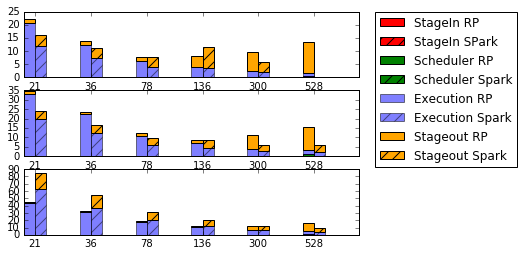

In [22]:
bar_l = np.arange(6)
width=0.20
a=plt.figure()
plt.title('Mean Task BreakDown')
plt.subplot(3, 1, 1)
#Stage IN
plt.bar(bar_l,[rp_haus_21_32_short['StageInDelay'].mean(),\
               rp_haus_36_24_short['StageInDelay'].mean(),\
               rp_haus_78_16_short['StageInDelay'].mean(),\
               rp_haus_136_12_short['StageInDelay'].mean(),\
               rp_haus_300_8_short['StageInDelay'].mean(),\
               rp_haus_528_6_short['StageInDelay'].mean()],
        width,alpha=1.0,
        label='StageIn RP',color='r')

plt.bar(bar_l+width,spco_stagein_short_ca,
        width,alpha=1.0,
        hatch='//',
        label='StageIn SPark',color='r')

# Scheduling
plt.bar(bar_l,[rp_haus_21_32_short['SchedulerDelay'].mean(),\
               rp_haus_36_24_short['SchedulerDelay'].mean(),\
               rp_haus_78_16_short['SchedulerDelay'].mean(),\
               rp_haus_136_12_short['SchedulerDelay'].mean(),\
               rp_haus_300_8_short['SchedulerDelay'].mean(),\
               rp_haus_528_6_short['SchedulerDelay'].mean()],
        width,alpha=1.0,bottom=[rp_haus_21_32_short['StageInDelay'].mean(),\
               rp_haus_36_24_short['StageInDelay'].mean(),\
               rp_haus_78_16_short['StageInDelay'].mean(),\
               rp_haus_136_12_short['StageInDelay'].mean(),\
               rp_haus_300_8_short['StageInDelay'].mean(),\
               rp_haus_528_6_short['StageInDelay'].mean()],
        label='Scheduler RP',color='g')

plt.bar(bar_l+width,spco_schedulerdelay_short_ca,
        width,alpha=1.0,bottom=spco_stagein_short_ca,
        hatch='//',label='Scheduler Spark',color='g')

# Executing
plt.bar(bar_l,[rp_haus_21_32_short['Execution'].mean(),\
               rp_haus_36_24_short['Execution'].mean(),\
               rp_haus_78_16_short['Execution'].mean(),\
               rp_haus_136_12_short['Execution'].mean(),\
               rp_haus_300_8_short['Execution'].mean(),\
               rp_haus_528_6_short['Execution'].mean()],
        width,alpha=0.5,
        bottom=[rp_haus_21_32_short['SchedulerDelay'].mean()+rp_haus_21_32_short['StageInDelay'].mean(),\
                rp_haus_36_24_short['SchedulerDelay'].mean()+rp_haus_36_24_short['StageInDelay'].mean(),\
                rp_haus_78_16_short['SchedulerDelay'].mean()+rp_haus_78_16_short['StageInDelay'].mean(),\
                rp_haus_136_12_short['SchedulerDelay'].mean()+rp_haus_136_12_short['StageInDelay'].mean(),\
                rp_haus_300_8_short['SchedulerDelay'].mean()+rp_haus_300_8_short['StageInDelay'].mean(),\
                rp_haus_528_6_short['SchedulerDelay'].mean()+rp_haus_528_6_short['StageInDelay'].mean()],
        label='Execution RP')

plt.bar(bar_l+width,spco_execution_short_ca,
        width,alpha=0.5,
        bottom=spco_stagein_short_ca+spco_schedulerdelay_short_ca,
        hatch='//',
        label='Execution Spark')

# Stage out and Finalization
plt.bar(bar_l,[rp_haus_21_32_short['StageOut'].mean(),\
               rp_haus_36_24_short['StageOut'].mean(),\
               rp_haus_78_16_short['StageOut'].mean(),\
               rp_haus_136_12_short['StageOut'].mean(),\
               rp_haus_300_8_short['StageOut'].mean(),\
               rp_haus_528_6_short['StageOut'].mean()],
        width,alpha=1.0,
        bottom=[rp_haus_21_32_short['Execution'].mean()+rp_haus_21_32_short['SchedulerDelay'].mean()+rp_haus_21_32_short['StageInDelay'].mean(),\
                rp_haus_36_24_short['Execution'].mean()+rp_haus_36_24_short['SchedulerDelay'].mean()+rp_haus_36_24_short['StageInDelay'].mean(),\
                rp_haus_78_16_short['Execution'].mean()+rp_haus_78_16_short['SchedulerDelay'].mean()+rp_haus_78_16_short['StageInDelay'].mean(),\
                rp_haus_136_12_short['Execution'].mean()+rp_haus_136_12_short['SchedulerDelay'].mean()+rp_haus_136_12_short['StageInDelay'].mean(),\
                rp_haus_300_8_short['Execution'].mean()+rp_haus_300_8_short['SchedulerDelay'].mean()+rp_haus_300_8_short['StageInDelay'].mean(),\
                rp_haus_528_6_short['Execution'].mean()+rp_haus_528_6_short['SchedulerDelay'].mean()+rp_haus_528_6_short['StageInDelay'].mean()],
        label='Stageout RP',color='orange')

plt.bar(bar_l+width,spco_stageout_short_ca,
        width,alpha=1.0,
        bottom=spco_stagein_short_ca+spco_schedulerdelay_short_ca+spco_execution_short_ca,
        hatch='//',label='Stageout Spark',color='orange')
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(bar_l + width, ('21', '36', '78', '136', '300','528'))


plt.subplot(3, 1, 2)
# Stage In

plt.bar(bar_l,[rp_haus_21_32_med['StageInDelay'].mean(),\
               rp_haus_36_24_med['StageInDelay'].mean(),\
               rp_haus_78_16_med['StageInDelay'].mean(),\
               rp_haus_136_12_med['StageInDelay'].mean(),\
               rp_haus_300_8_med['StageInDelay'].mean(),\
               rp_haus_528_6_med['StageInDelay'].mean()],
        width,alpha=1.0,
        label='StageIn',color='r')

plt.bar(bar_l+width,spco_stagein_med_ca,
        width,alpha=1.0,
        hatch='//',
        label='StageIn',color='r')

# Scheduling Delay
plt.bar(bar_l,[rp_haus_21_32_med['SchedulerDelay'].mean(),\
               rp_haus_36_24_med['SchedulerDelay'].mean(),\
               rp_haus_78_16_med['SchedulerDelay'].mean(),\
               rp_haus_136_12_med['SchedulerDelay'].mean(),\
               rp_haus_300_8_med['SchedulerDelay'].mean(),\
               rp_haus_528_6_med['SchedulerDelay'].mean()],
        width,alpha=1.0,bottom=[rp_haus_21_32_med['StageInDelay'].mean(),\
               rp_haus_36_24_med['StageInDelay'].mean(),\
               rp_haus_78_16_med['StageInDelay'].mean(),\
               rp_haus_136_12_med['StageInDelay'].mean(),\
               rp_haus_300_8_med['StageInDelay'].mean(),\
               rp_haus_528_6_med['StageInDelay'].mean()],
        label='Scheduler',color='g')

plt.bar(bar_l+width,spco_schedulerdelay_med_ca,
        width,alpha=1.0,bottom=spco_stagein_med_ca,
        hatch='//',label='Scheduler',color='g')

# Execution 
plt.bar(bar_l,[rp_haus_21_32_med['Execution'].mean(),\
               rp_haus_36_24_med['Execution'].mean(),\
               rp_haus_78_16_med['Execution'].mean(),\
               rp_haus_136_12_med['Execution'].mean(),\
               rp_haus_300_8_med['Execution'].mean(),\
               rp_haus_528_6_med['Execution'].mean()],
        width,alpha=0.5,
        bottom=[rp_haus_21_32_med['SchedulerDelay'].mean()+rp_haus_21_32_med['StageInDelay'].mean(),\
                rp_haus_36_24_med['SchedulerDelay'].mean()+rp_haus_36_24_med['StageInDelay'].mean(),\
                rp_haus_78_16_med['SchedulerDelay'].mean()+rp_haus_78_16_med['StageInDelay'].mean(),\
                rp_haus_136_12_med['SchedulerDelay'].mean()+rp_haus_136_12_med['StageInDelay'].mean(),\
                rp_haus_300_8_med['SchedulerDelay'].mean()+rp_haus_300_8_med['StageInDelay'].mean(),\
                rp_haus_528_6_med['SchedulerDelay'].mean()+rp_haus_528_6_med['StageInDelay'].mean()],
        label='Execution')

plt.bar(bar_l+width,spco_execution_med_ca,
        width,alpha=0.5,
        bottom=spco_stagein_med_ca+spco_schedulerdelay_med_ca,
        hatch='//',
        label='Execution Spark')

# Stage Out
plt.bar(bar_l,[rp_haus_21_32_med['StageOut'].mean(),\
               rp_haus_36_24_med['StageOut'].mean(),\
               rp_haus_78_16_med['StageOut'].mean(),\
               rp_haus_136_12_med['StageOut'].mean(),\
               rp_haus_300_8_med['StageOut'].mean(),\
               rp_haus_528_6_med['StageOut'].mean()],
        width,alpha=1.0,
        bottom=[rp_haus_21_32_med['Execution'].mean()+rp_haus_21_32_med['SchedulerDelay'].mean()+rp_haus_21_32_med['StageInDelay'].mean(),\
                rp_haus_36_24_med['Execution'].mean()+rp_haus_36_24_med['SchedulerDelay'].mean()+rp_haus_36_24_med['StageInDelay'].mean(),\
                rp_haus_78_16_med['Execution'].mean()+rp_haus_78_16_med['SchedulerDelay'].mean()+rp_haus_78_16_med['StageInDelay'].mean(),\
                rp_haus_136_12_med['Execution'].mean()+rp_haus_136_12_med['SchedulerDelay'].mean()+rp_haus_136_12_med['StageInDelay'].mean(),\
                rp_haus_300_8_med['Execution'].mean()+rp_haus_300_8_med['SchedulerDelay'].mean()+rp_haus_300_8_med['StageInDelay'].mean(),\
                rp_haus_528_6_med['Execution'].mean()+rp_haus_528_6_med['SchedulerDelay'].mean()+rp_haus_528_6_med['StageInDelay'].mean()],
        label='Stageout',color='orange')

plt.bar(bar_l+width,spco_stageout_med_ca,
        width,alpha=1.0,
        bottom=spco_stagein_med_ca+spco_schedulerdelay_med_ca+spco_execution_med_ca,
        hatch='//',label='Stageout',color='orange')

plt.xticks(bar_l + width, ('21', '36', '78', '136', '300','528'))
plt.subplot(3, 1, 3)

# Stage In
plt.bar(bar_l,[rp_haus_21_32_long['StageInDelay'].mean(),\
               rp_haus_36_24_long['StageInDelay'].mean(),\
               rp_haus_78_16_long['StageInDelay'].mean(),\
               rp_haus_136_12_long['StageInDelay'].mean(),\
               rp_haus_300_8_long['StageInDelay'].mean(),\
               rp_haus_528_6_long['StageInDelay'].mean()],
        width,alpha=1.0,
        label='StageIn',color='r')

plt.bar(bar_l+width,spco_stagein_long_ca,
        width,alpha=1.0,
        hatch='//',
        label='StageIn',color='r')

#Scheduling Delay
plt.bar(bar_l,[rp_haus_21_32_long['SchedulerDelay'].mean(),\
               rp_haus_36_24_long['SchedulerDelay'].mean(),\
               rp_haus_78_16_long['SchedulerDelay'].mean(),\
               rp_haus_136_12_long['SchedulerDelay'].mean(),\
               rp_haus_300_8_long['SchedulerDelay'].mean(),\
               rp_haus_528_6_long['SchedulerDelay'].mean()],
        width,alpha=1.0,bottom=[rp_haus_21_32_long['StageInDelay'].mean(),\
               rp_haus_36_24_long['StageInDelay'].mean(),\
               rp_haus_78_16_long['StageInDelay'].mean(),\
               rp_haus_136_12_long['StageInDelay'].mean(),\
               rp_haus_300_8_long['StageInDelay'].mean(),\
               rp_haus_528_6_long['StageInDelay'].mean()],
        label='Scheduler',color='g')

plt.bar(bar_l+width,spco_schedulerdelay_long_ca,
        width,alpha=1.0,bottom=spco_stagein_long_ca,
        hatch='//',label='Scheduler',color='g')

# Execution
plt.bar(bar_l,[rp_haus_21_32_long['Execution'].mean(),\
               rp_haus_36_24_long['Execution'].mean(),\
               rp_haus_78_16_long['Execution'].mean(),\
               rp_haus_136_12_long['Execution'].mean(),\
               rp_haus_300_8_long['Execution'].mean(),\
               rp_haus_528_6_long['Execution'].mean()],
        width,alpha=0.5,
        bottom=[rp_haus_21_32_long['SchedulerDelay'].mean()+rp_haus_21_32_long['StageInDelay'].mean(),\
                rp_haus_36_24_long['SchedulerDelay'].mean()+rp_haus_36_24_long['StageInDelay'].mean(),\
                rp_haus_78_16_long['SchedulerDelay'].mean()+rp_haus_78_16_long['StageInDelay'].mean(),\
                rp_haus_136_12_long['SchedulerDelay'].mean()+rp_haus_136_12_long['StageInDelay'].mean(),\
                rp_haus_300_8_long['SchedulerDelay'].mean()+rp_haus_300_8_long['StageInDelay'].mean(),\
                rp_haus_528_6_long['SchedulerDelay'].mean()+rp_haus_528_6_long['StageInDelay'].mean()],
        label='Execution')

plt.bar(bar_l+width,spco_execution_long_ca,
        width,alpha=0.5,
        bottom=spco_stagein_long_ca+spco_schedulerdelay_long_ca,
        hatch='//',
        label='Execution')

# Stage Out
plt.bar(bar_l,[rp_haus_21_32_long['StageOut'].mean(),\
               rp_haus_36_24_long['StageOut'].mean(),\
               rp_haus_78_16_long['StageOut'].mean(),\
               rp_haus_136_12_long['StageOut'].mean(),\
               rp_haus_300_8_long['StageOut'].mean(),\
               rp_haus_528_6_long['StageOut'].mean()],
        width,alpha=1.0,
        bottom=[rp_haus_21_32_long['Execution'].mean()+rp_haus_21_32_long['SchedulerDelay'].mean()+rp_haus_21_32_long['StageInDelay'].mean(),\
                rp_haus_36_24_long['Execution'].mean()+rp_haus_36_24_long['SchedulerDelay'].mean()+rp_haus_36_24_long['StageInDelay'].mean(),\
                rp_haus_78_16_long['Execution'].mean()+rp_haus_78_16_long['SchedulerDelay'].mean()+rp_haus_78_16_long['StageInDelay'].mean(),\
                rp_haus_136_12_long['Execution'].mean()+rp_haus_136_12_long['SchedulerDelay'].mean()+rp_haus_136_12_long['StageInDelay'].mean(),\
                rp_haus_300_8_long['Execution'].mean()+rp_haus_300_8_long['SchedulerDelay'].mean()+rp_haus_300_8_long['StageInDelay'].mean(),\
                rp_haus_528_6_long['Execution'].mean()+rp_haus_528_6_long['SchedulerDelay'].mean()+rp_haus_528_6_long['StageInDelay'].mean()],
        label='Stageout',color='orange')

plt.bar(bar_l+width,spco_stageout_long_ca,
        width,alpha=1.0,
        bottom=spco_stagein_long_ca+spco_schedulerdelay_long_ca+spco_execution_long_ca,
        hatch='//',label='Stageout ',color='orange')
plt.xticks(bar_l + width, ('21', '36', '78', '136', '300','528'))
plt.savefig('MeanTaskBreakDownPr.pdf',bbox_extra_artists=(lgd,),bbox_inches='tight')

In [27]:
haus_med_read = np.array([haus_21_32_med_exec_detail['Read'].mean(),\
                          haus_36_24_med_exec_detail['Read'].mean(),\
                          haus_78_16_med_exec_detail['Read'].mean(),\
                         haus_136_12_med_exec_detail['Read'].mean(),\
                          haus_300_8_med_exec_detail['Read'].mean(),\
                          haus_528_6_med_exec_detail['Read'].mean()])

haus_med_exec = np.array([haus_21_32_med_exec_detail['Exec'].mean(),\
                          haus_36_24_med_exec_detail['Exec'].mean(),\
                          haus_78_16_med_exec_detail['Exec'].mean(),\
                         haus_136_12_med_exec_detail['Exec'].mean(),\
                          haus_300_8_med_exec_detail['Exec'].mean(),\
                          haus_528_6_med_exec_detail['Exec'].mean()])

haus_med_write = np.array([haus_21_32_med_exec_detail['Write'].mean(),\
                           haus_36_24_med_exec_detail['Write'].mean(),\
                           haus_78_16_med_exec_detail['Write'].mean(),\
                           haus_136_12_med_exec_detail['Write'].mean(),\
                           haus_300_8_med_exec_detail['Write'].mean(),\
                           haus_528_6_med_exec_detail['Write'].mean()])

print haus_med_read
print haus_med_exec
print haus_med_write
print haus_21_32_med_exec_detail

[ 0.90663967  0.97442828  0.4732941   0.24708537  0.17977268  0.07048679]
[ 42.09187662  25.70340247  11.45205818   7.08370761   3.24401828
   1.85761192]
[ 0.01168024  0.00794572  0.00187899  0.00179123  0.00188875  0.05985468]
        Read       Exec     Write
0   1.161243  47.568997  0.015729
1   1.047776  48.703286  0.021018
2   1.315634  19.553040  0.002992
3   1.323230  47.664695  0.047324
4   0.898327  49.244150  0.013827
5   0.599272  45.745034  0.024901
6   0.960855  47.427330  0.002385
7   1.006272  37.957969  0.003809
8   0.674757  48.121838  0.004966
9   1.086013  48.602706  0.019085
10  0.337305  23.107362  0.011167
11  0.947801  19.130270  0.004002
12  0.814154  48.301719  0.014514
13  0.503514  49.125861  0.018708
14  1.135889  44.942722  0.005400
15  0.899491  49.281482  0.002089
16  0.718640  47.800309  0.004729
17  1.272572  44.394270  0.002635
18  0.260076  49.170970  0.002874
19  1.207253  44.952808  0.007362
20  0.869359  23.132591  0.015769


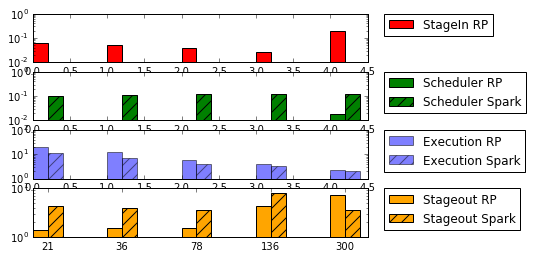

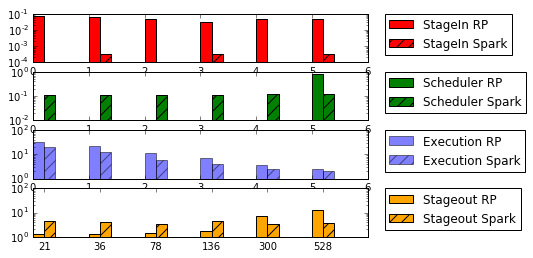

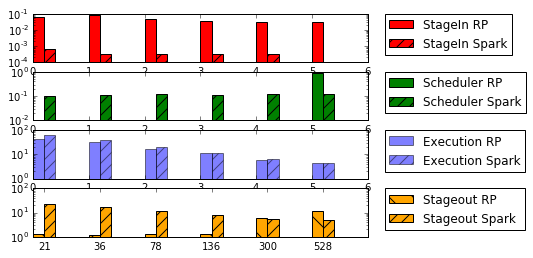

In [29]:
bar_l = np.arange(5)
width=0.20
a=plt.figure()
plt.title('Mean Task BreakDown')
plt.subplot(4, 1, 1)
#Stage IN
plt.bar(bar_l,[rp_haus_21_32_short['StageInDelay'].mean(),\
               rp_haus_36_24_short['StageInDelay'].mean(),\
               rp_haus_78_16_short['StageInDelay'].mean(),\
               rp_haus_136_12_short['StageInDelay'].mean(),\
               rp_haus_300_8_short['StageInDelay'].mean()],
        width,alpha=1.0,log=1,
        label='StageIn RP',color='r')

#plt.bar(bar_l+width,spco_stagein_short_ca[0:5],
#        width,alpha=1.0,
#        hatch='//',log=1,
#        label='StageIn Spark',color='r')
lgd1 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Scheduling
plt.subplot(4, 1, 2)
plt.bar(bar_l,[rp_haus_21_32_short['SchedulerDelay'].mean(),\
               rp_haus_36_24_short['SchedulerDelay'].mean(),\
               rp_haus_78_16_short['SchedulerDelay'].mean(),\
               rp_haus_136_12_short['SchedulerDelay'].mean(),\
               rp_haus_300_8_short['SchedulerDelay'].mean()],
        width,alpha=1.0,label='Scheduler RP',color='g',log=1)

plt.bar(bar_l+width,spco_schedulerdelay_short_ca[0:5],
        width,alpha=1.0,log=1,
        hatch='//',label='Scheduler Spark',color='g')
lgd2 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Executing
plt.subplot(4, 1, 3)
haus_short_read = [haus_21_32_short_exec_detail['Read'].mean(),\
                   haus_36_24_short_exec_detail['Read'].mean(),\
                   haus_78_16_short_exec_detail['Read'].mean(),\
                   haus_136_12_short_exec_detail['Read'].mean(),\
                   haus_300_8_short_exec_detail['Read'].mean()]

haus_short_exec = [haus_21_32_short_exec_detail['Exec'].mean(),\
                   haus_36_24_short_exec_detail['Exec'].mean(),\
                   haus_78_16_short_exec_detail['Exec'].mean(),\
                   haus_136_12_short_exec_detail['Exec'].mean(),\
                   haus_300_8_short_exec_detail['Exec'].mean()]

plt.bar(bar_l,[rp_haus_21_32_short['Execution'].mean(),\
               rp_haus_36_24_short['Execution'].mean(),\
               rp_haus_78_16_short['Execution'].mean(),\
               rp_haus_136_12_short['Execution'].mean(),\
               rp_haus_300_8_short['Execution'].mean()],
        width,alpha=0.5,log=1,
        label='Execution RP')

plt.bar(bar_l+width,spco_execution_short_ca[0:5],
        width,alpha=0.5,
        hatch='//',log=1,
        label='Execution Spark')
lgd3 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Stage out and Finalization
plt.subplot(4, 1, 4)
plt.bar(bar_l,[rp_haus_21_32_short['StageOut'].mean(),\
               rp_haus_36_24_short['StageOut'].mean(),\
               rp_haus_78_16_short['StageOut'].mean(),\
               rp_haus_136_12_short['StageOut'].mean(),\
               rp_haus_300_8_short['StageOut'].mean()],
        width,alpha=1.0,log=1,
        label='Stageout RP',color='orange')

plt.bar(bar_l+width,spco_stageout_short_ca[0:5],
        width,alpha=1.0,log=1,
        hatch='//',label='Stageout Spark',color='orange')
lgd4 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(bar_l + width, ('21', '36', '78', '136', '300','528'))
plt.savefig('DetailedMeanTaskBreakDownShortPr.pdf',bbox_extra_artists=(lgd1,lgd2,lgd3,lgd4,),bbox_inches='tight')
bar_l = np.arange(6)
plt.figure()
# Stage In
plt.subplot(4, 1, 1)
plt.bar(bar_l,[rp_haus_21_32_med['StageInDelay'].mean(),\
               rp_haus_36_24_med['StageInDelay'].mean(),\
               rp_haus_78_16_med['StageInDelay'].mean(),\
               rp_haus_136_12_med['StageInDelay'].mean(),\
               rp_haus_300_8_med['StageInDelay'].mean(),\
               rp_haus_528_6_med['StageInDelay'].mean()],
        width,alpha=1.0,
        label='StageIn RP',color='r')

plt.bar(bar_l+width,spco_stagein_med_ca,
        width,alpha=1.0,
        hatch='//',log=1,
        label='StageIn Spark',color='r')
lgd1 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Scheduling Delay
plt.subplot(4, 1, 2)
plt.bar(bar_l,[rp_haus_21_32_med['SchedulerDelay'].mean(),\
               rp_haus_36_24_med['SchedulerDelay'].mean(),\
               rp_haus_78_16_med['SchedulerDelay'].mean(),\
               rp_haus_136_12_med['SchedulerDelay'].mean(),\
               rp_haus_300_8_med['SchedulerDelay'].mean(),\
               rp_haus_528_6_med['SchedulerDelay'].mean()],
        width,alpha=1.0,log=1,label='Scheduler RP',color='g')

plt.bar(bar_l+width,spco_schedulerdelay_med_ca,
        width,alpha=1.0,log=1,
        hatch='//',label='Scheduler Spark',color='g')

lgd2 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Execution 
plt.subplot(4, 1, 3)
plt.bar(bar_l,[rp_haus_21_32_med['Execution'].mean(),\
               rp_haus_36_24_med['Execution'].mean(),\
               rp_haus_78_16_med['Execution'].mean(),\
               rp_haus_136_12_med['Execution'].mean(),\
               rp_haus_300_8_med['Execution'].mean(),\
               rp_haus_528_6_med['Execution'].mean()],
        width,alpha=0.5,log=1,
        label='Execution RP')

plt.bar(bar_l+width,spco_execution_med_ca,
        width,alpha=0.5,
        hatch='//',log=1,
        label='Execution Spark')

lgd3 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Stage Out
plt.subplot(4, 1, 4)
plt.bar(bar_l,[rp_haus_21_32_med['StageOut'].mean(),\
               rp_haus_36_24_med['StageOut'].mean(),\
               rp_haus_78_16_med['StageOut'].mean(),\
               rp_haus_136_12_med['StageOut'].mean(),\
               rp_haus_300_8_med['StageOut'].mean(),\
               rp_haus_528_6_med['StageOut'].mean()],
        width,alpha=1.0,log=1,
        label='Stageout RP',color='orange')

plt.bar(bar_l+width,spco_stageout_med_ca,
        width,alpha=1.0,log=1,
        hatch='//',label='Stageout Spark',color='orange')

lgd4 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xticks(bar_l + width, ('21', '36', '78', '136', '300','528'))
plt.savefig('DetailedMeanTaskBreakDownMedPr.pdf',bbox_extra_artists=(lgd1,lgd2,lgd3,lgd4,),bbox_inches='tight')

plt.figure()
# Stage In
plt.subplot(4, 1, 1)
plt.bar(bar_l,[rp_haus_21_32_long['StageInDelay'].mean(),\
               rp_haus_36_24_long['StageInDelay'].mean(),\
               rp_haus_78_16_long['StageInDelay'].mean(),\
               rp_haus_136_12_long['StageInDelay'].mean(),\
               rp_haus_300_8_long['StageInDelay'].mean(),\
               rp_haus_528_6_long['StageInDelay'].mean()],
        width,alpha=1.0,log=1,
        label='StageIn RP',color='r')

plt.bar(bar_l+width,spco_stagein_long_ca,
        width,alpha=1.0,
        hatch='//',log=1,
        label='StageIn Spark',color='r')
lgd1 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#Scheduling Delay
plt.subplot(4, 1, 2)
plt.bar(bar_l,[rp_haus_21_32_long['SchedulerDelay'].mean(),\
               rp_haus_36_24_long['SchedulerDelay'].mean(),\
               rp_haus_78_16_long['SchedulerDelay'].mean(),\
               rp_haus_136_12_long['SchedulerDelay'].mean(),\
               rp_haus_300_8_long['SchedulerDelay'].mean(),\
               rp_haus_528_6_long['SchedulerDelay'].mean()],
        width,alpha=1.0,log=1,
        label='Scheduler RP',color='g')

plt.bar(bar_l+width,spco_schedulerdelay_long_ca,
        width,alpha=1.0,
        hatch='//',label='Scheduler Spark',color='g')
lgd2 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Execution
plt.subplot(4, 1, 3)
plt.bar(bar_l,[rp_haus_21_32_long['Execution'].mean(),\
               rp_haus_36_24_long['Execution'].mean(),\
               rp_haus_78_16_long['Execution'].mean(),\
               rp_haus_136_12_long['Execution'].mean(),\
               rp_haus_300_8_long['Execution'].mean(),\
               rp_haus_528_6_long['Execution'].mean()],
        width,alpha=0.5,log=1,
        label='Execution RP')

plt.bar(bar_l+width,spco_execution_long_ca,
        width,alpha=0.5,
        hatch='//',log=1,
        label='Execution Spark')

lgd3 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Stage Out
plt.subplot(4, 1, 4)
plt.bar(bar_l,[rp_haus_21_32_long['StageOut'].mean(),\
               rp_haus_36_24_long['StageOut'].mean(),\
               rp_haus_78_16_long['StageOut'].mean(),\
               rp_haus_136_12_long['StageOut'].mean(),\
               rp_haus_300_8_long['StageOut'].mean(),\
               rp_haus_528_6_long['StageOut'].mean()],
        width,alpha=1.0,log=1,
        hatch='\\',label='Stageout RP',color='orange')

plt.bar(bar_l+width,spco_stageout_long_ca,
        width,alpha=1.0,log=1,
        hatch='//',label='Stageout Spark ',color='orange')
plt.xticks(bar_l + width, ('21', '36', '78', '136', '300','528'))
lgd4 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('DetailedMeanTaskBreakDownLongPr.pdf',bbox_extra_artists=(lgd1,lgd2,lgd3,lgd4,),bbox_inches='tight')

In [ ]:
print rp_haus_overall
rp_haus_overall['Mean'][0:5].plot.bar(yerr=rp_haus_overall['Std'])

In [ ]:
rp_haus_528_6_short_ca_3

# Analysis and Modeling

## Definitions

$N_I$: Number of Input files

$S_I$: Size of each file

$k$: Number of tasks

$N_O$: Number of Output files

$S_O$: Size of each file

$\alpha$: the coefficient of Staging In

$\beta$: the coefficient of the Scheduling delay

$\gamma$: the coefficient of the Execution

$\delta$: the coefficient of the Staging Out

## General Analysis

The execution model can be easily broken to different parts.  First part of the model is data StageIn. In case of RADICAL-Pilot StageIn is rather easy to undeerstand. In case of Spark, I consider as StageIn the part of the code that is written before partitioning the data. Second part is the time need to schedule a task. Third is the actual execution of the task, which can be broken further more to read, exec and write. Finally, the last part of the model is the time necessary to stage out the data. In case of RADICAL-Pilot it is easy to understand. In Spark, I consider as the time needed from the time that all tasks have returned their data until the end of the script.

Essentially, the model will look like:

$$T=\alpha(N_I S_I)+\beta\frac{k(k+1)}{2}+\gamma Y+\delta\Big{(}N_O S_O + \frac{k(k+1)}{2}\Big{)}$$

$Y$ is the tme of the execution of the task.


## Analysis of Task Execution

That is dependent to the number of trajectories being processed and the number of points in each trajectory. Let $T_N$ be the number of trajectories per task and $T_S$ the size of each trajectory, i.e. the number of points.Thus, the above execution time can be

$$Y = (T_N T_S)r+{T_N}^2 dH +{T_N}^2 w$$

Let $dH$ be the time to calculate the Hausdorff distance between two trajectories. The following algorithm describes it in pseudocode. The description will help the following analysis

Let $T_1$ and $T_2$ be the two trajectories

For $\forall t_1\in T_1$ do:

&nbsp;&nbsp;For $\forall t_2\in T_2$ do:

&nbsp;&nbsp;&nbsp;&nbsp;Append in $D_1$ d($t_1, t_2$)

&nbsp;&nbsp;EndDo

&nbsp;&nbsp;D = max($D_1$)

EndFor

$N_1$=max(D)

For $\forall t_2\in T_2$ do:

&nbsp;&nbsp;For $\forall t_1\in T_1$ do:

&nbsp;&nbsp;&nbsp;&nbsp;Append in $D_2$ d($t_2, t_1$);

&nbsp;&nbsp;EndDo

&nbsp;&nbsp;D = max($D_2$)

EndFor

$N_2$=max(D)

Return max($N_1, N_2$)


Thus $dH$ is $$dH =\mathcal{O}({T_S}^2) + T_S \mathcal{O}(T_S) + \mathcal{O}({T_S}^2) + T_S \mathcal{O}(T_S)$$


## System Solving

C is the coefficient vector. y is the total execution times and A will be the matrix that holds the several values. The calculations will happen for CA short and it will verifythe other 2.

Also, simple division will be done between the known values end their respective time to check 

### RP fitting

#### Small Data set

In [29]:
y=np.array([rp_haus_21_32_short['TotalTime'].mean(),\
            rp_haus_36_24_short['TotalTime'].mean(),\
            rp_haus_78_16_short['TotalTime'].mean(),\
            rp_haus_136_12_short['TotalTime'].mean()])
print y
A = np.array(([64*85,21,rp_haus_21_32_short['Execution'].mean(),21],
              [48*85,36,rp_haus_36_24_short['Execution'].mean(),36],
              [32*85,78,rp_haus_78_16_short['Execution'].mean(),78],
              [24*85,136,rp_haus_136_12_short['Execution'].mean(),136]))
print A
C = np.linalg.solve(A, y)
print C

[ 20.83152014  12.18815162   6.06983352   3.94762929]
[[  5.44000000e+03   2.10000000e+01   2.07635511e+01   2.10000000e+01]
 [  4.08000000e+03   3.60000000e+01   1.21358488e+01   3.60000000e+01]
 [  2.72000000e+03   7.80000000e+01   6.03011796e+00   7.80000000e+01]
 [  2.04000000e+03   1.36000000e+02   3.91804321e+00   1.36000000e+02]]
[  1.35982738e-05   9.88078551e+11   9.99759894e-01  -9.88078551e+11]


In [30]:
a = np.array([16*85,300,rp_haus_300_8_short['Execution'].mean(),300])

test1 = np.inner(a,C)

print 'Small: Predicted Total Time 300 tasks:',test1,'Actual Mean Total Time:',rp_haus_300_8_short['TotalTime'].mean(), 'Error:',rp_haus_300_8_short['TotalTime'].mean()-test1

a = np.array([12*85,528,rp_haus_528_6_short['Execution'].mean(),528])

test1 = np.inner(a,C)

print 'Small: Predicted Total Time 528 tasks:',test1,'Actual Mean Total Time:',rp_haus_528_6_short['TotalTime'].mean(), 'Error:',rp_haus_528_6_short['TotalTime'].mean()-test1


Small: Predicted Total Time 300 tasks: 2.19505713407 Actual Mean Total Time: 2.38752645466 Error: 0.192469320591
Small: Predicted Total Time 528 tasks: 1.26865175492 Actual Mean Total Time: 1.61307469131 Error: 0.344422936393


#### Medium Dataset

In [31]:
a = np.array([64*85,21,rp_haus_21_32_med['Execution'].mean(),21])

test1 = np.inner(a,C)

print 'Medium: Predicted Total Time 21 tasks:',test1,'Actual Mean Total Time:',rp_haus_21_32_med['TotalTime'].mean(), 'Error:',rp_haus_21_32_med['TotalTime'].mean()-test1

a = np.array([48*85,36,rp_haus_36_24_med['Execution'].mean(),36])

test1 = np.inner(a,C)

print 'Medium: Predicted Total Time 36 tasks:',test1,'Actual Mean Total Time:',rp_haus_36_24_med['TotalTime'].mean(), 'Error:',rp_haus_36_24_med['TotalTime'].mean()-test1

a = np.array([32*85,78,rp_haus_78_16_med['Execution'].mean(),78])

test1 = np.inner(a,C)

print 'Medium: Predicted Total Time 78 tasks:',test1,'Actual Mean Total Time:',rp_haus_78_16_med['TotalTime'].mean(), 'Error:',rp_haus_78_16_med['TotalTime'].mean()-test1

a = np.array([24*85,136,rp_haus_136_12_med['Execution'].mean(),136])

test1 = np.inner(a,C)

print 'Medium: Predicted Total Time 136 tasks:',test1,'Actual Mean Total Time:',rp_haus_136_12_med['TotalTime'].mean(), 'Error:',rp_haus_136_12_med['TotalTime'].mean()-test1

a = np.array([16*85,300,rp_haus_300_8_med['Execution'].mean(),300])

test1 = np.inner(a,C)

print 'Medium: Predicted Total Time 300 tasks:',test1,'Actual Mean Total Time:',rp_haus_300_8_med['TotalTime'].mean(), 'Error:',rp_haus_300_8_med['TotalTime'].mean()-test1

a = np.array([12*85,528,rp_haus_528_6_med['Execution'].mean(),528])

test1 = np.inner(a,C)

print 'Medium: Predicted Total Time 528 tasks:',test1,'Actual Mean Total Time:',rp_haus_528_6_med['TotalTime'].mean(), 'Error:',rp_haus_528_6_med['TotalTime'].mean()-test1

Medium: Predicted Total Time 21 tasks: 33.3136668993 Actual Mean Total Time: 33.3253119711 Error: 0.0116450718086
Medium: Predicted Total Time 36 tasks: 22.2328782699 Actual Mean Total Time: 22.2469520392 Error: 0.0140737693618
Medium: Predicted Total Time 78 tasks: 10.8452443487 Actual Mean Total Time: 10.8571666795 Error: 0.0119223308157
Medium: Predicted Total Time 136 tasks: 6.8738059856 Actual Mean Total Time: 6.88058625833 Error: 0.00678027273885
Medium: Predicted Total Time 300 tasks: 3.63918139191 Actual Mean Total Time: 3.67618065543 Error: 0.0369992635193
Medium: Predicted Total Time 528 tasks: 2.40475870352 Actual Mean Total Time: 3.23822765489 Error: 0.833468951372


#### Large Dataset

In [32]:
a = np.array([64*85,21,rp_haus_21_32_long['Execution'].mean(),21])

test1 = np.inner(a,C)

print 'Long: Predicted Total Time 21 tasks:',test1,'Actual Mean Total Time:',rp_haus_21_32_long['TotalTime'].mean(), 'Error:',rp_haus_21_32_long['TotalTime'].mean()-test1

a = np.array([48*85,36,rp_haus_36_24_long['Execution'].mean(),36])

test1 = np.inner(a,C)

print 'Long: Predicted Total Time 36 tasks:',test1,'Actual Mean Total Time:',rp_haus_36_24_long['TotalTime'].mean(), 'Error:',rp_haus_36_24_long['TotalTime'].mean()-test1

a = np.array([32*85,78,rp_haus_78_16_long['Execution'].mean(),78])

test1 = np.inner(a,C)

print 'Long: Predicted Total Time 78 tasks:',test1,'Actual Mean Total Time:',rp_haus_78_16_long['TotalTime'].mean(), 'Error:',rp_haus_78_16_long['TotalTime'].mean()-test1

a = np.array([24*85,136,rp_haus_136_12_long['Execution'].mean(),136])

test1 = np.inner(a,C)

print 'Long: Predicted Total Time 136 tasks:',test1,'Actual Mean Total Time:',rp_haus_136_12_long['TotalTime'].mean(), 'Error:',rp_haus_136_12_long['TotalTime'].mean()-test1

a = np.array([16*85,300,rp_haus_300_8_long['Execution'].mean(),300])

test1 = np.inner(a,C)

print 'Long: Predicted Total Time 300 tasks:',test1,'Actual Mean Total Time:',rp_haus_300_8_long['TotalTime'].mean(), 'Error:',rp_haus_300_8_long['TotalTime'].mean()-test1

a = np.array([12*85,528,rp_haus_528_6_long['Execution'].mean(),528])

test1 = np.inner(a,C)

print 'Long: Predicted Total Time 528 tasks:',test1,'Actual Mean Total Time:',rp_haus_528_6_long['TotalTime'].mean(), 'Error:',rp_haus_528_6_long['TotalTime'].mean()-test1

Long: Predicted Total Time 21 tasks: 43.8873638582 Actual Mean Total Time: 43.8923199669 Error: 0.00495610872072
Long: Predicted Total Time 36 tasks: 30.9028212926 Actual Mean Total Time: 30.9349148759 Error: 0.0320935833527
Long: Predicted Total Time 78 tasks: 17.1266483406 Actual Mean Total Time: 17.1459104994 Error: 0.0192621588231
Long: Predicted Total Time 136 tasks: 11.1204478449 Actual Mean Total Time: 11.1351985826 Error: 0.0147507377432
Long: Predicted Total Time 300 tasks: 4.34514286961 Actual Mean Total Time: 5.26987538991 Error: 0.924732520303
Long: Predicted Total Time 528 tasks: 4.34051945651 Actual Mean Total Time: 5.26987538991 Error: 0.929355933395


### Spark fitting

#### Small Dataset

Trajectory Read: 8.4
Scheduling Delay: 11.5657272727
Task REW: 5.68579734848
Total Task Life: 17.2515246212

Read + Task Life: 21.394
Spark Script Time minus (Read+Task Life): 24.276
5.26987538991


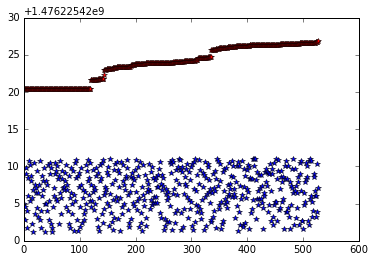

In [259]:
print 'Trajectory Read:', SparkExps['DataInit'][53]
print 'Scheduling Delay:', SparkExps['appData'][53]['SchedulerDelay'].mean()/1000
print 'Task REW:',(SparkExps['appData'][53]['Runtime']+SparkExps['appData'][53]['DeserializeTime']+SparkExps['appData'][53]['ResultSerialization']).mean()/1000
print 'Total Task Life:',((SparkExps['appData'][53]['FinishTime'] - SparkExps['appData'][53]['LaunchTime']).mean()/1000)
print ''
print  'Read + Task Life:',(SparkExps['DataInit'][53] + \
      ((SparkExps['appData'][53]['FinishTime'][284]-SparkExps['appData'][53]['LaunchTime'][346]).mean()/1000))
print 'Spark Script Time - (Read+Task Life):',SparkExps['TotalTime'][53]-(SparkExps['DataInit'][53] + \
      ((SparkExps['appData'][53]['FinishTime'][284]-SparkExps['appData'][53]['LaunchTime'][346]).mean()/1000))

print 'RADICAL-Pilot Mean CU:', rp_haus_528_6_long['TotalTime'].mean()

plt.plot(SparkExps['appData'][53]['LaunchTime']/1000,'b*')
plt.plot(SparkExps['appData'][53]['FinishTime']/1000,'r*')

In [172]:
y=np.array([(spco_stageout_short_ca+spco_stagein_short_ca+spco_schedulerdelay_short_ca+spco_execution_short_ca)[0].mean(),\
            (spco_stageout_short_ca+spco_stagein_short_ca+spco_schedulerdelay_short_ca+spco_execution_short_ca)[1].mean(),\
            (spco_stageout_short_ca+spco_stagein_short_ca+spco_schedulerdelay_short_ca+spco_execution_short_ca)[2].mean(),\
            (spco_stageout_short_ca+spco_stagein_short_ca+spco_schedulerdelay_short_ca+spco_execution_short_ca)[3].mean()])


A = np.array(([48555744,21,spco_execution_short_ca[0],294992/21 + 21],
              [48555744,36,spco_execution_short_ca[1],294992/36 + 36],
              [48555744,78,spco_execution_short_ca[2],294992/78 + 78],
              [48555744,136,spco_execution_short_ca[3],294992/136 + 136]))

D = np.linalg.solve(A, y)
print D
a = np.array([48555744,300,spco_execution_short_ca[0],294912/21 + 21])

test1 = np.inner(a,D)

print 'Small: Predicted Total Time 300 tasks:',test1,'Actual Mean Total Time:',(spco_stageout_short_ca+spco_stagein_short_ca+spco_schedulerdelay_short_ca+spco_execution_short_ca)[0].mean(), 'Error:',(spco_stageout_short_ca+spco_stagein_short_ca+spco_schedulerdelay_short_ca+spco_execution_short_ca)[0].mean()-test1




[  1.73986914e-07   1.65912569e-02   9.13465024e-01   3.40745254e-04]
Small: Predicted Total Time 300 tasks: 30.6275976993 Actual Mean Total Time: 26.0 Error: -4.62759769929


In [166]:
a = np.array([48555744,300,spco_execution_short_ca[4],294912/300+300])

test1 = np.inner(a,D)

print 'Small: Predicted Total Time 300 tasks:',test1,'Actual Mean Total Time:',(spco_stageout_short_ca+spco_stagein_short_ca+spco_schedulerdelay_short_ca+spco_execution_short_ca)[4].mean(), 'Error:',SparkExps['TotalTime'][12:15].mean()-test1

a = np.array([48555744,528,spco_execution_short_ca[5],294912/528+528])

test1 = np.inner(a,D)

print 'Small: Predicted Total Time 528 tasks:',test1,'Actual Mean Total Time:',(spco_stageout_short_ca+spco_stagein_short_ca+spco_schedulerdelay_short_ca+spco_execution_short_ca)[5].mean(), 'Error:',SparkExps['TotalTime'][15:18].mean()-test1

Small: Predicted Total Time 300 tasks: 17.0306673126 Actual Mean Total Time: 24.6666666667 Error: 1.96933268741
Small: Predicted Total Time 528 tasks: 20.0541413234 Actual Mean Total Time: 28.0 Error: 1.94585867656


In [150]:
a = np.array([97111488,21,spco_execution_med_ca[0].mean(),294912])

test1 = np.inner(a,D)

print 'Medium: Predicted Total Time 21 tasks:',test1,'Actual Mean Total Time:',SparkExps['TotalTime'][18:21].mean(), 'Error:',SparkExps['TotalTime'][18:21].mean()-test1

a = np.array([97111488,36,spco_execution_med_ca[1],294912])

test1 = np.inner(a,D)

print 'Medium: Predicted Total Time 36 tasks:',test1,'Actual Mean Total Time:',SparkExps['TotalTime'][21:24].mean(), 'Error:',rp_haus_36_24_med['TotalTime'].mean()-test1

a = np.array([97111488,78,spco_execution_med_ca[2],294912])

test1 = np.inner(a,D)

print 'Medium: Predicted Total Time 78 tasks:',test1,'Actual Mean Total Time:',rp_haus_78_16_med['TotalTime'].mean(), 'Error:',rp_haus_78_16_med['TotalTime'].mean()-test1

a = np.array([97111488,136,spco_execution_med_ca[3],294912])

test1 = np.inner(a,D)

print 'Medium: Predicted Total Time 136 tasks:',test1,'Actual Mean Total Time:',rp_haus_136_12_med['TotalTime'].mean(), 'Error:',rp_haus_136_12_med['TotalTime'].mean()-test1

a = np.array([97111488,300,spco_execution_med_ca[4],294912])

test1 = np.inner(a,D)

print 'Medium: Predicted Total Time 300 tasks:',test1,'Actual Mean Total Time:',rp_haus_300_8_med['TotalTime'].mean(), 'Error:',rp_haus_300_8_med['TotalTime'].mean()-test1

a = np.array([97111488,528,spco_execution_med_ca[5],294912])

test1 = np.inner(a,D)

print 'Medium: Predicted Total Time 528 tasks:',test1,'Actual Mean Total Time:',rp_haus_528_6_med['TotalTime'].mean(), 'Error:',rp_haus_528_6_med['TotalTime'].mean()-test1

Medium: Predicted Total Time 21 tasks: 118.819239748 Actual Mean Total Time: 35.3333333333 Error: -83.4859064144
Medium: Predicted Total Time 36 tasks: 108.524012292 Actual Mean Total Time: 22.6666666667 Error: -86.2770602526
Medium: Predicted Total Time 78 tasks: 103.26024404 Actual Mean Total Time: 10.8571666795 Error: -92.4030773608
Medium: Predicted Total Time 136 tasks: 103.924102453 Actual Mean Total Time: 6.88058625833 Error: -97.0435161948
Medium: Predicted Total Time 300 tasks: 109.329720293 Actual Mean Total Time: 3.67618065543 Error: -105.653539637
Medium: Predicted Total Time 528 tasks: 120.853325224 Actual Mean Total Time: 3.23822765489 Error: -117.615097569
